# Initialization

In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import statsmodels.api as sm
import plotly.express as px
import seaborn as sb
import pandas as pd
from openpyxl import load_workbook
import os
from scipy.optimize import minimize
from colorama import Fore, Style
import time
import matplotlib.patches as patches
from tqdm.notebook import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.covariance import LedoitWolf
import plotly.graph_objects as go
import random
import warnings

warnings.filterwarnings("ignore", category=FutureWarning, module="yfinance")


def get_sub(x):
    normal = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789+-=()"
    sub_s = "ₐ₈CDₑբGₕᵢⱼₖₗₘₙₒₚQᵣₛₜᵤᵥwₓᵧZₐ♭꜀ᑯₑբ₉ₕᵢⱼₖₗₘₙₒₚ૧ᵣₛₜᵤᵥwₓᵧ₂₀₁₂₃₄₅₆₇₈₉₊₋₌₍₎"
    res = x.maketrans(''.join(normal), ''.join(sub_s)) #normal=1st dict / sub_s=2nd dict, like applymap
    return x.translate(res) #so as to return a text and not a dict, according to the key x in the res (dict)

bbox_props = dict(boxstyle='square', pad=0.3, fc='white', ec='black', lw=1.65)

dir_ = os.getcwd()
dir_

'/Users/grtk/Desktop/Python'

In [2]:
interval='1mo'

In [3]:
market_df = yf.download('^GSPC', interval=interval).dropna()  #^FCHI ^GDAXI ^IXIC ^RUT ^GSPC
market_df['Chg'] = market_df['Adj Close'].pct_change()
ten_year = yf.download('^TNX').reindex(market_df.index)['Close'].div(100).fillna(method='ffill')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/var/folders/k8/nm1rvlt97lgdk7xbhcdy3h5r0000gn/T/ipykernel_30432/3557963266.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ten_year = yf.download('^TNX').reindex(market_df.index)['Close'].div(100).fillna(method='ffill')


In [323]:
def equal_industry(industries_df, sample=1, industry_col='Industry', ticker_col='Ticker', exclude=[], only=[]):
    sample_df = []
    ind_col_name = str(industry_col)
    if len(only) != 0:
        industries_to_see = only
    else:
        industries_to_see = np.setdiff1d(industries_df[ind_col_name].unique(), exclude)
        
    for industry in industries_to_see:
        try:
            industry_sample = industries_df[industries_df[ind_col_name] == industry].sample(n=sample)
            sample_df.append(industry_sample)
        except: #sample > available
            industry_sample = industries_df[industries_df[ind_col_name] == industry]
            sample_df.append(industry_sample)
        new_ind_df = industries_df[[str(ticker_col), str(industry_col)]].rename(columns={str(ticker_col): 'Ticker', str(industry_col): 'Industry'})
    return pd.concat(sample_df)[str(ticker_col)].tolist(), new_ind_df

def clean_df(df):
    na_tickers = (df['Close'].isna().sum()  > df['Close'].shape[0] / 2)
    na_tickers = na_tickers[na_tickers==True].index

    new_cols=pd.Index((set(df.Close.columns) - set(na_tickers)))

    df = df.loc[:, pd.IndexSlice[:,new_cols]].sort_index(axis=1)
    return df

In [326]:
#Tickers / Index Initialization

megatickers = pd.read_csv(dir_+'/csv/nasdaq_screener_1688898573156.csv')
cac40=cac40=pd.read_excel(dir_+'/csv/cac40iq.xls')
cac40['Ticker'] = [t[7:]+'.PA' for t in cac40['Ticker']]
dax=pd.read_excel(dir_+'/csv/DAX.xlsx')['Symbole']
russel=pd.read_excel(dir_+'/csv/russell_2000_components.xls').sample(n=50)['Ticker']
sp_full=pd.read_csv(dir_+'/csv/SPfull.csv', sep=';')
#tickers=cac40['Symbole']
#tickers=dax
#tickers=megatickers['Symbol']
#tickers=russel
#tickers=equal_industry(sp_big_cap,2,'Sector')
tickers, industries = equal_industry(sp_full, 4, industry_col='Industry', exclude=['Energy','Real Estate'], only=[]) #name of the column 'Industry'
#tickers, industries = equal_industry(sp_full, 5, industry_col='Industry', only=['Industrials','Health Care']) #name of the column 'Industry'
#tickers=pd.concat([cac40['Symbole'],megatickers['Symbol']])
#elements_to_remove = ['TSLA', 'NVDA', 'BABA', '#BRK/A', 'BRK/B', 'PCGU', 'UG.PA', 'FP.PA', 'ATO.PA', 
#                      'WLN.PA', 'VIV.PA', 'PFE', 'MRK', 'HD','XOM', 'TM', 'SHEL']
#elements_to_remove = ['BAC','NVS','NVO','LLY','AMZN','WMT','ORCL']
elements_to_remove = ['SAN.PA','CA.PA','AC.PA','ACA.PA', 'TSLA']

for e in elements_to_remove:
    try:
        tickers.remove(e)
    except:
        pass 

#tickers=['AAPL','ADBE','AMZN','ASML','CRM','GOOG','GOOGL','META','MSFT','NOW','PG','SHEL','TSM']

df = yf.download(tickers, period="16Y",interval=interval).drop(['Close'], axis=1).rename(columns={'Adj Close': 'Close'})
df.index = pd.to_datetime(df.index)
#df.index = df.index.strftime('%Y-%m-%d')
#excel_writer = pd.ExcelWriter('/Users/grtk/Desktop/stocks.xlsx')

df = clean_df(df)
df

[*********************100%***********************]  143 of 143 completed

1 Failed download:
- CDAY: No data found, symbol may be delisted


Close                                                          \
                 ACGL        ADM        AEP         AIZ      AMCR         AME   
Date                                                                            
2008-05-01   7.817778  26.599539  22.306248   49.300133       NaN   20.556456   
2008-06-01   7.368889  22.681082  21.397581   47.902386       NaN   18.921562   
2008-07-01   7.747778  19.240278  21.009314   43.661175       NaN   19.200499   
2008-08-01   7.751111  17.109934  20.764650   42.433842       NaN   19.473299   
2008-09-01   8.114444  14.799765  19.899588   40.040497       NaN   16.356131   
...               ...        ...        ...         ...       ...         ...   
2024-01-01  82.430000  55.059299  77.250786  167.235733  9.301034  161.798431   
2024-02-01  87.589996  52.612438  84.220558  180.678329  8.936094  179.900269   
2024-03-01  92.440002  62.810001  86.099998  188.240005  9.510000  182.616043   
2024-04-01  93.540001  58.660000  86.029999  174.399994  8.940000  174.660004   
2024-05-01  94.769997  59.119999  87.029999  176.154999  9.850000  174.910004   

                                                           ...       Volume  \
                  AMZN         APD       APTV        AXON  ...          WBD   
Date                                                       ...                
2008-05-01    4.081000   63.009850        NaN    7.030000  ...   93215628.0   
2008-06-01    3.666500   61.118069        NaN    4.990000  ...  116137186.0   
2008-07-01    3.817000   59.125656        NaN    5.040000  ...  117198076.0   
2008-08-01    4.040500   57.039062        NaN    6.500000  ...  157839878.0   
2008-09-01    3.638000   42.532459        NaN    7.150000  ...  119814196.0   
...                ...         ...        ...         ...  ...          ...   
2024-01-01  155.199997  253.848190  81.330002  249.059998  ...  396226500.0   
2024-02-01  176.759995  232.335968  79.489998  307.369995  ...  602786700.0   
2024-03-01  180.380005  240.506042  79.650002  312.880005  ...  607419000.0   
2024-04-01  175.000000  236.339996  71.000000  313.660004  ...  632036400.0   
2024-05-01  177.859406  237.490005  69.930000  312.725006  ...   13212191.0   

                                                                         \
                    WDC         WEC         WRB         WRK         WST   
Date                                                                      
2008-05-01  107194200.0  25104200.0  42767550.0         NaN   8068400.0   
2008-06-01  114137200.0  33283000.0  44136675.0         NaN  10189600.0   
2008-07-01  153533200.0  43872600.0  63438525.0         NaN  11591200.0   
2008-08-01   83628800.0  27689000.0  41141925.0         NaN  11553000.0   
2008-09-01  100853800.0  39579400.0  80417925.0         NaN  12350000.0   
...                 ...         ...         ...         ...         ...   
2024-01-01  170346700.0  59155900.0  28087800.0  44433800.0   9309900.0   
2024-02-01  109135900.0  42235900.0  21940300.0  44694500.0  14417300.0   
2024-03-01  140105700.0  40662800.0  22565900.0  43153700.0   9912600.0   
2024-04-01  172042900.0  34786500.0  32887300.0  42574000.0   9381400.0   
2024-05-01    2401379.0    557763.0    282292.0    205199.0     95846.0   

                                                             
                   WTW        WYNN          YUM         ZBH  
Date                                                         
2008-05-01   3957143.0  33802400.0   84213507.0  59737322.0  
2008-06-01   8463244.0  57066100.0  110418555.0  34505927.0  
2008-07-01   9143310.0  78375600.0  148629882.0  54619870.0  
2008-08-01   8857053.0  42820100.0   76066419.0  26833766.0  
2008-09-01  13735711.0  43746300.0  129196499.0  45657428.0  
...                ...         ...          ...         ...  
2024-01-01   8002500.0  40782700.0   32385100.0  35313000.0  
2024-02-01  10243300.0  40076900.0   44333100.0  35544600.0  
2024-03-01  10106900.0  32332600.0   4179

In [327]:
if interval=='1wk':
    if not (df.index[-1] + pd.offsets.Week(-1)) == df.index[-2]:
        df = df[:-1]
elif interval=='1mo':
    if not (df.index[-1] + pd.DateOffset(months=-1)) == df.index[-2]:
    #if not df.index[-1].is_month_start
        df = df[:-1]

market_df = market_df.reindex(df.index)
df_return = df['Close'].pct_change()

# Portfolio configuration

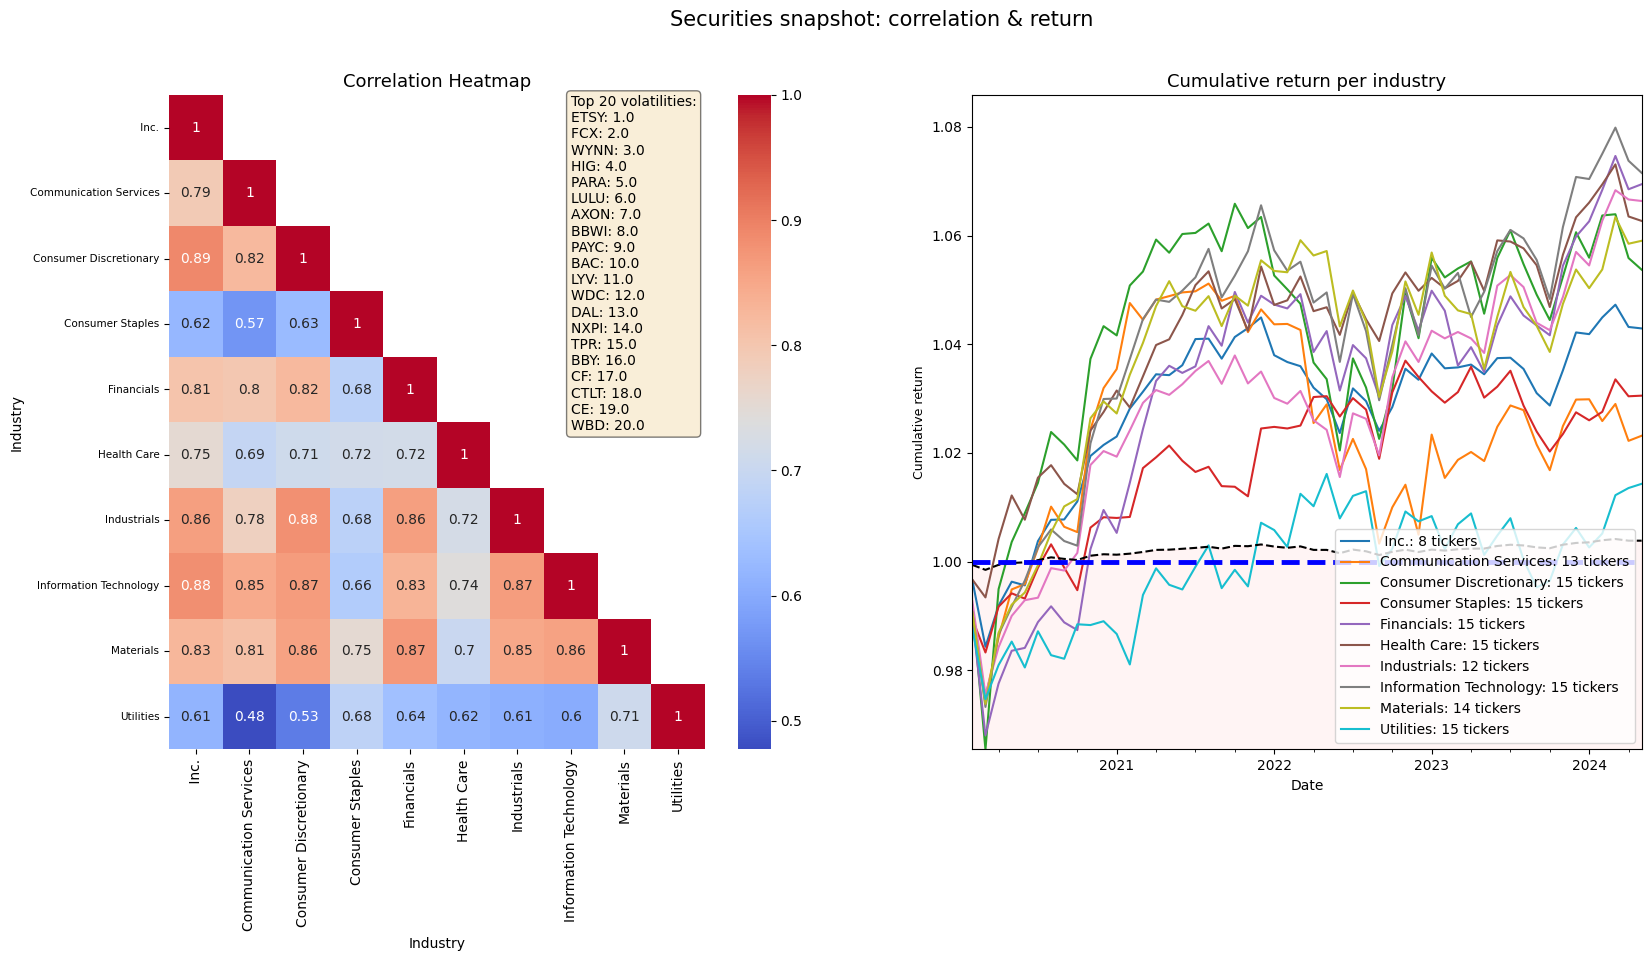

In [328]:
#.groupby(['Industry','Date']).mean().unstack(level=0).pct_change().dropna().corr()
basis_df = df.loc['2020':,'Close'].pct_change().reset_index().iloc[1:].melt(id_vars='Date', var_name='Ticker', value_name='Price').merge(industries, on='Ticker')
nb_tickers = basis_df.drop_duplicates(subset='Ticker').Industry.value_counts() #pour plot 2
basis_df = basis_df.groupby(['Industry','Date']).sum(numeric_only=True).div(df['Close'].shape[1]).unstack(level=0)#.div(df['Close'].shape[1])
#reset_index().pivot(columns='Industry', index='Date') #same as unstack()
basis_df.columns = basis_df.columns.droplevel(0)
#basis_df = basis_df[['Real Estate','Utilities']]
corr_close = basis_df.corr()
cumprod_df_industry = (1+basis_df).cumprod()


fig, axes = plt.subplots(1,2, figsize=(19, 8.5))
fig.suptitle('Securities snapshot: correlation & return', fontsize=15)
axes[0].set_title('Correlation Heatmap', fontsize=13)

#Plot 1
mask = np.triu(np.ones_like(corr_close, dtype=bool), 1)
sb.heatmap(corr_close, mask=mask, annot=True, cmap="coolwarm", ax=axes[0], fmt='.2g')
#axes[0].set_xticks(np.arange(len(corr_close.columns)), corr_close.columns, rotation=35, ha='left', fontsize=7.5)
#axes[0].yticks(np.arange(len(corr_close.columns)), corr_close.columns, rotation=0, fontsize=7.5)
axes[0].set_yticklabels(corr_close.columns, rotation=0, fontsize=7.5)
top20voltxt = '\n'.join([f'{ticker}: {volrank}' for ticker, volrank in df['Close'].pct_change().std().rank(ascending=0).sort_values()[:20].items()])
axes[0].text(.75, 1, 'Top 20 volatilities:\n' + top20voltxt, transform=axes[0].transAxes, fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

#Plot 2
cumprod_df_industry.plot(ax=axes[1])
new_legend = []
[new_legend.append(f'{col}: {nb_tickers[col]} tickers') for col in cumprod_df_industry]
mkt_basis=(1+market_df['Close'].pct_change().div(df['Close'].shape[1])).reindex(cumprod_df_industry.index).cumprod()
mkt_basis.plot(ax=axes[1], label='Market', c='black', ls='--')
axes[1].fill_between(mkt_basis.index, mkt_basis, axes[1].get_ylim()[0], color='red', alpha=0.0414)
axes[1].set_ylabel('Cumulative return', fontsize=9)
axes[1].set_title('Cumulative return per industry', fontsize=13)
axes[1].axhline(y=1, lw=3.5, ls='--', c='b')
axes[1].set_ylim(cumprod_df_industry.min().min())
#axes[1].set_yscale('log')
axes[1].legend(new_legend)
plt.show()

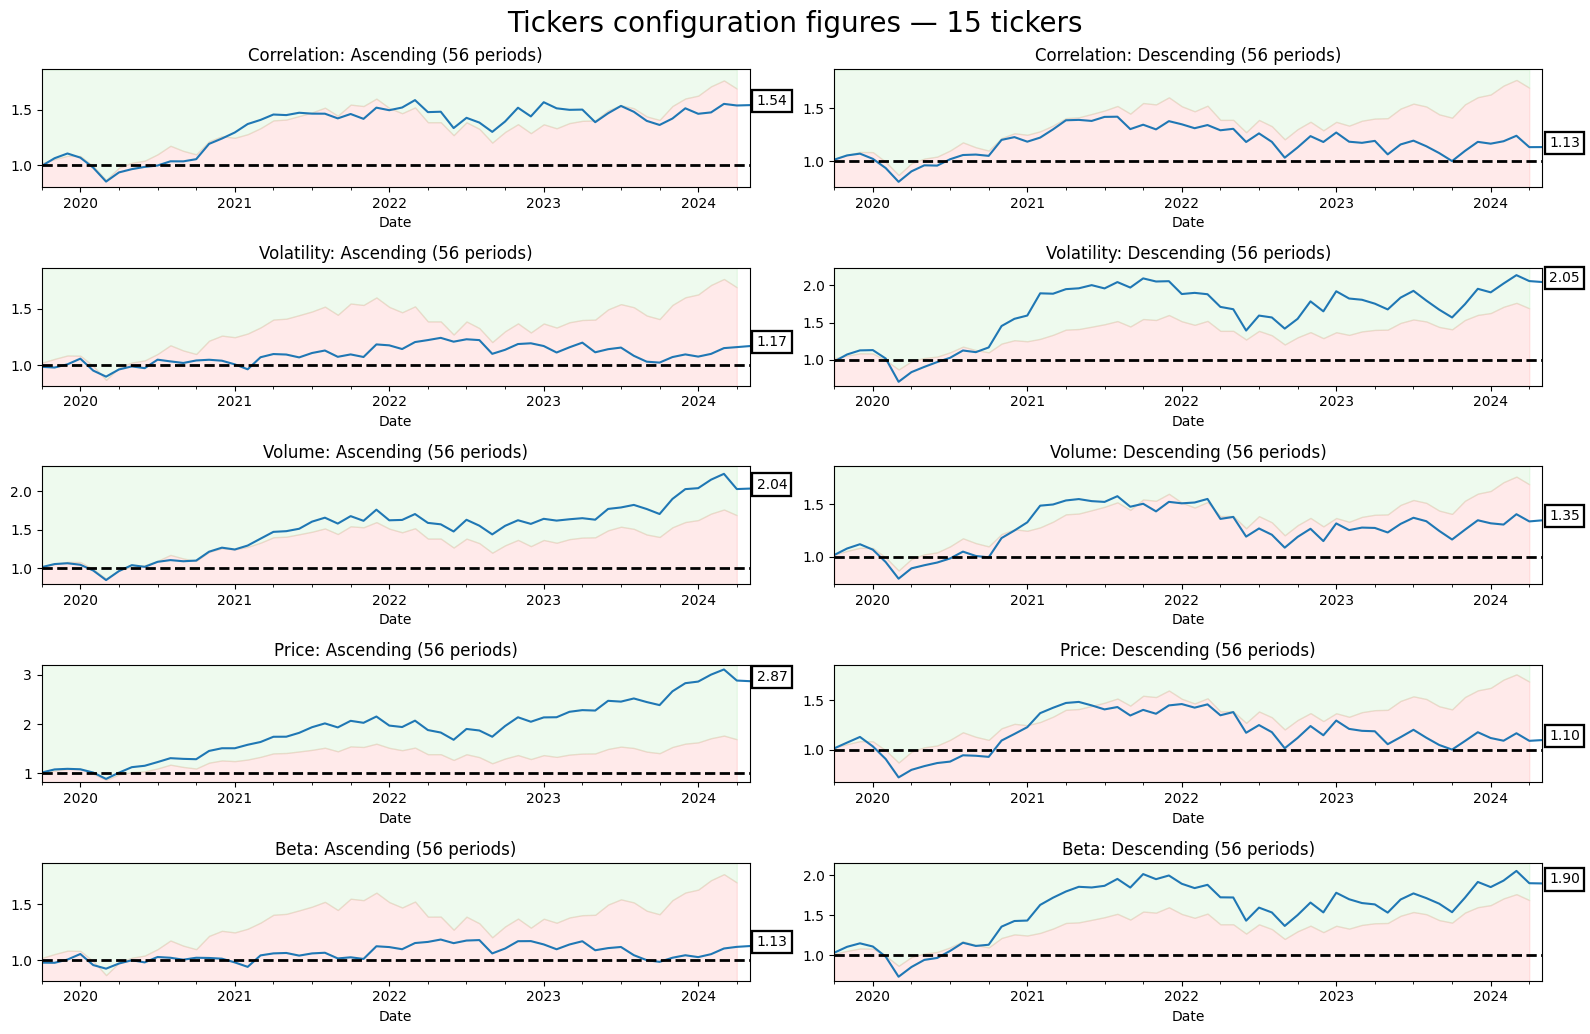

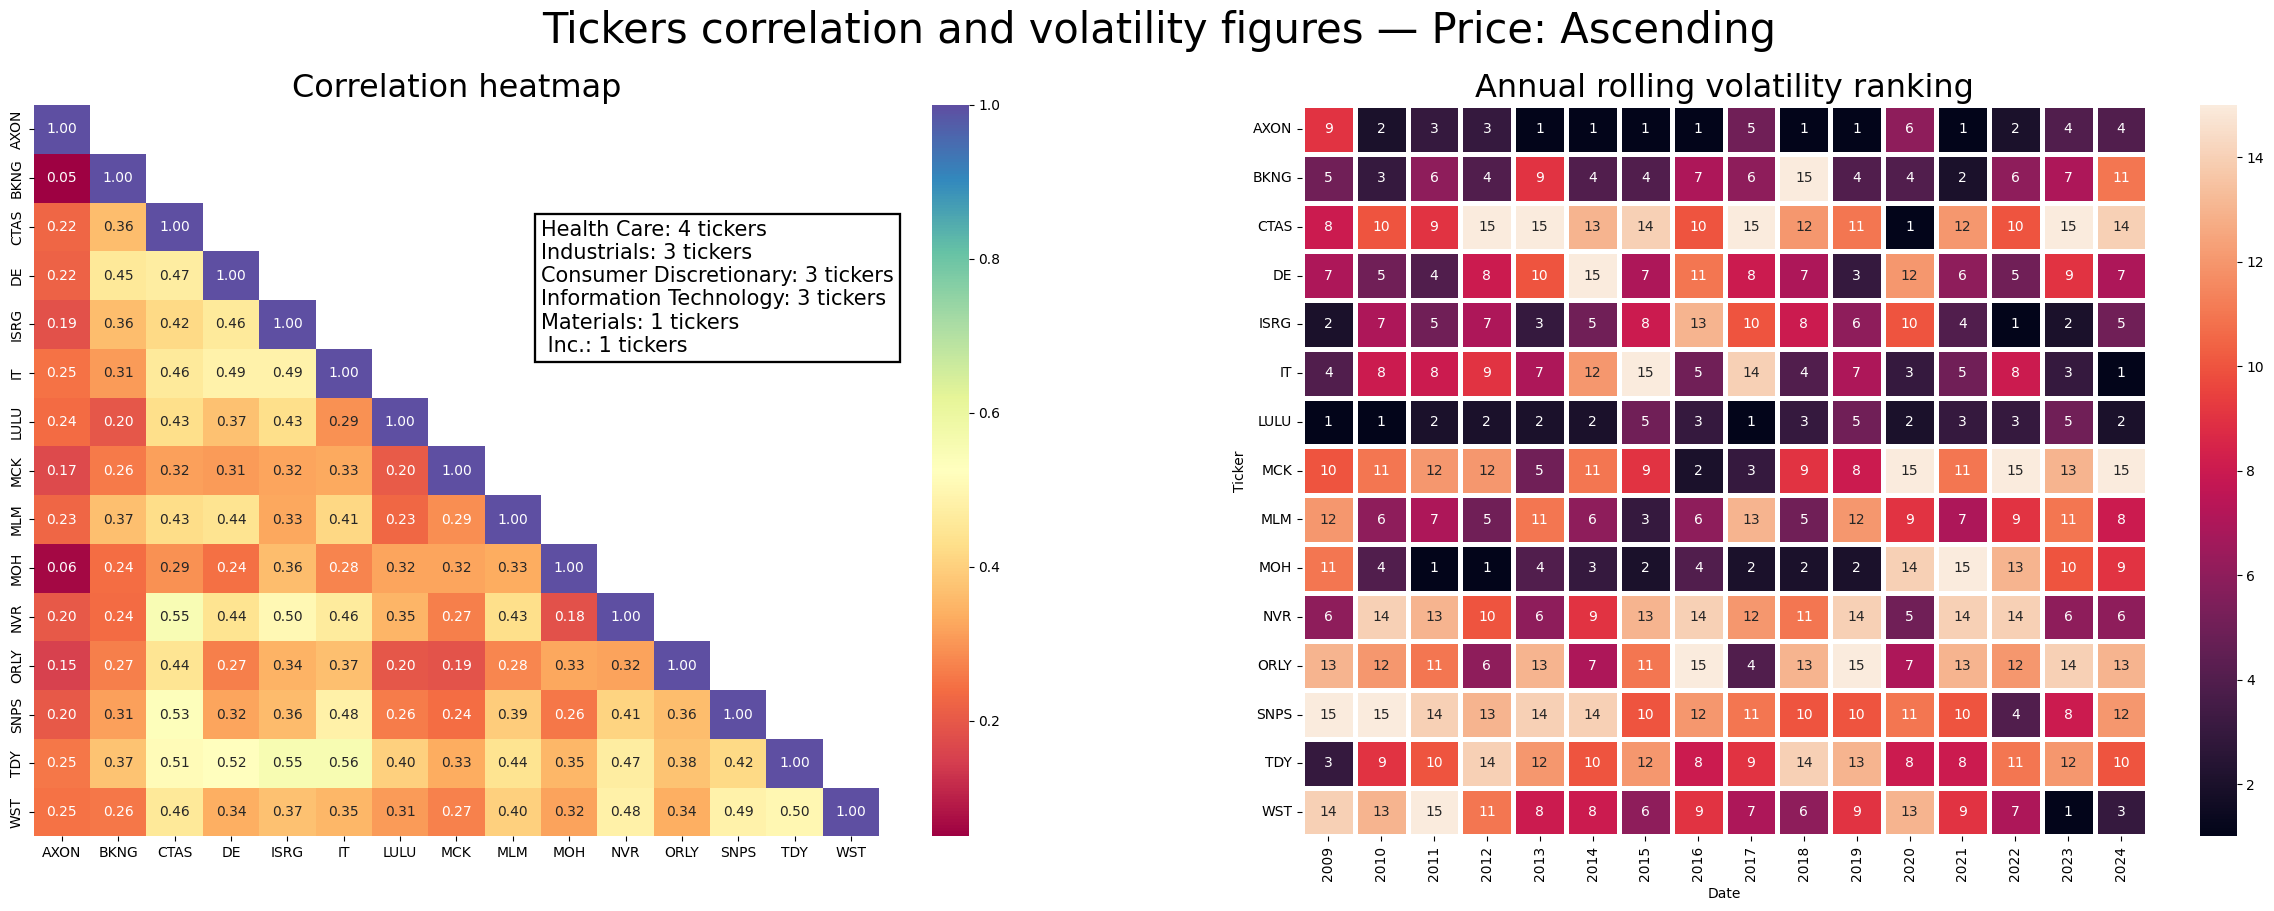

In [329]:
def plot_tickers_config(market_df, df, nombre_tickers, list_tts="default"):

    
    corr_close_price = df['Close'].pct_change().corr()
    #differentes configs
    ttsac, ttsdc = corr_close_price.min().sort_values(ascending=True)[:nombre_tickers].index, corr_close_price.min().sort_values(ascending=False)[:nombre_tickers].index #ascending corr
    ttsas, ttsds = df['Close'].pct_change().std().sort_values(ascending=True)[:nombre_tickers].index, df['Close'].pct_change().std().sort_values(ascending=False)[:nombre_tickers].index #ascending std
    ttsav, ttsdv = df['Volume'].iloc[-nb_rolling:].mean().sort_values(ascending=True)[:nombre_tickers].index, df['Volume'].iloc[-nb_rolling:].mean().sort_values(ascending=False)[:nombre_tickers].index #ascending volume
    ttsap, ttsdp = pd.Series([df['Close'][tick].dropna().iat[-1]-df['Close'][tick].dropna().iat[0] for tick in df['Close'].columns], index=df['Close'].columns).sort_values(ascending=False)[:nombre_tickers].index, pd.Series([df['Close'][tick].dropna().iat[-1]-df['Close'][tick].dropna().iat[0] for tick in df['Close'].columns], index=df['Close'].columns).sort_values(ascending=True)[:nombre_tickers].index #ascending differences in price: tricky one
    beta_df = pd.concat([df['Close'].pct_change().iloc[1:], market_df['Close'].pct_change().iloc[1:]], axis=1).dropna(axis=1).cov()
    beta_list = [(stock, beta_df.at[stock, 'Close'] / beta_df.at['Close', 'Close']) for stock in beta_df.columns.difference(['Close'])]
    ttsab, ttsdb = pd.DataFrame(beta_list).set_index(0).sort_values(by=1, ascending=True)[:nombre_tickers].index, pd.DataFrame(beta_list).set_index(0).sort_values(by=1, ascending=False)[:nombre_tickers].index # ascending beta
    
    list_tickers_to_see = [ttsac, ttsdc, ttsas, ttsds, ttsav, ttsdv, ttsap, ttsdp, ttsab, ttsdb]
    list_tickers_to_see = [df.Close.columns for a in list_tickers_to_see] if len(df.Close.columns) <= nombre_tickers else list_tickers_to_see

    tickers_to_see, number_tts_text, max_tts = 0, 0, 0
    
    fig, ax = plt.subplots(int(len(list_tickers_to_see)/2), 2, figsize=(16, 10.5)) #autant de axs que de list_tickers_to_see
    fig.suptitle('Tickers configuration figures — {} tickers'.format(nombre_tickers), fontsize=20)
    mkt_ret=(market_df[period_to_start:]['Chg']+1).cumprod()
    investment_period = df[period_to_start:].shape[0]
    #plot pour chaque config avec equal weights
    for ax, ticker, num_it in zip(ax.ravel(), list_tickers_to_see, range(len(ax.ravel()))): #ou enumerate
        ret = df_return.loc[:,ticker]
        single_weight_equal=1/ret.shape[1]
        if_init_plot=((single_weight_equal*ret.loc[period_to_start:]).sum(axis=1)+1).cumprod()
        if_init_plot.plot(ax=ax)
        
        #check si return > last return pour avoir la meilleure config
        number_tts_text=num_it if if_init_plot.iloc[-1]>max_tts else number_tts_text #best list's number return
        tickers_to_see=list_tickers_to_see[num_it] if if_init_plot.iloc[-1]>max_tts else tickers_to_see #best list
        max_tts=max(if_init_plot.iloc[-1], max_tts)
        
        ax.axhline(y=1, color='black', linestyle='--', linewidth=2)
        maxv=max(max(if_init_plot), max(mkt_ret)) + 0.1
        minv=min(min(if_init_plot), min(mkt_ret)) - 0.05
        ax.fill_between(mkt_ret.index, mkt_ret, maxv, color='limegreen', alpha=0.08105)
        ax.fill_between(mkt_ret.index, mkt_ret, -3, color='red', alpha=0.08114)
        ax.set_ylim(minv,maxv)
        ax.set_xlim(mkt_ret.index[0], mkt_ret.index[-1])
        ax.set_title('{} ({} periods)'.format(tts_mapping[num_it], investment_period))
        ax.annotate('{:.2f}'.format(if_init_plot.iloc[-1]), xy=(if_init_plot.index[-1], if_init_plot.iloc[-1]), 
                   xytext=(5,0), textcoords='offset points', bbox=bbox_props)
        plt.tight_layout()
    if list_tts=='default':
        return tickers_to_see, number_tts_text, list_tickers_to_see
    else:
        return list_tickers_to_see[list_tts], list_tts, list_tickers_to_see

def which_config(list_tickers_to_see):
    for item in tts_mapping.items():
        print(item[0]+1,': ',item[1])
    selected_input=int(input('Select a configuration (default = highest return)\n'))-1
    if selected_input!='':
        return list_tickers_to_see[selected_input], selected_input

def plot_tickers_figures(tickers_to_see, tts_text):
    fig, axes = plt.subplots(1, 2, figsize=(30, 9.5))
    fig.suptitle('Tickers correlation and volatility figures — {}'.format(tts_text), fontsize=30)
    df_correlation_tickers_tosee = df['Close'][tickers_to_see].pct_change().corr().sort_index(axis=1).sort_index(axis=0)
    mask = np.triu(np.ones_like(df_correlation_tickers_tosee, dtype=bool), 1)
    sb.heatmap(df_correlation_tickers_tosee, mask=mask, annot=True, ax=axes[0], cmap='Spectral', fmt='.2f')
    axes[0].set_title('Correlation heatmap', size=23)
    txt = '\n'.join([f'{industry}: {count} tickers' for industry, count in industries[industries['Ticker'].isin(tickers_to_see)].Industry.value_counts().items()])
    axes[0].text(.6, .75, txt, bbox=bbox_props, color='black', fontsize=15, ha='left', va='center', transform=axes[0].transAxes)
    
    vol_ranking = df['Close'][tickers_to_see].pct_change().fillna(0).rolling(nb_rolling).var().resample('Y').last().dropna(axis=0).rank(axis=1, ascending=0).T.sort_index()
    ax = sb.heatmap(vol_ranking, linewidth=2.5, annot=True, ax=axes[1], cmap='rocket')
    ax.set(xlabel="Date", ylabel="Ticker", xticklabels=vol_ranking.columns.year)
    ax.set_yticklabels(vol_ranking.index, rotation=0)
    axes[1].set_title('Annual rolling volatility ranking', size=23)
    #txt = '\n'.join([f'{industry}: {count} tickers' for industry, count in pd.DataFrame({'Ticker':tickers_to_see}).merge(industries, on='Ticker')['Industry'].value_counts().items()])
    plt.show()



#############################################################
nb_rolling=52 if interval=='1wk' else 12
tts_mapping = {0: 'Correlation: Ascending', 1: 'Correlation: Descending', 2: 'Volatility: Ascending', 3: 'Volatility: Descending', 
               4: 'Volume: Ascending', 5: 'Volume: Descending', 6: 'Price: Ascending', 7: 'Price: Descending',
               8: 'Beta: Ascending', 9: 'Beta: Descending'}

nombre_tickers=15
cov_ma_period=8
cov_ma_period=cov_ma_period if interval=='1wk' else 4*cov_ma_period
min_pos=3
#period_to_start = '2017-09-26'
period_to_start = '2019-09-26'
#period_to_start = '2020-11-26'
#############################################################

tickers_to_see, tts, list_tickers_to_see = plot_tickers_config(market_df, df, nombre_tickers, list_tts='default')
plot_tickers_figures(tickers_to_see, tts_mapping[tts])

# Signals

In [330]:
def df_signals(df, market_df):

    df_signal = pd.DataFrame(df[['Close','Volume','Open','High','Low']])
    #.loc[:, (slice(None), tickers_to_see)])
    #df_signal.columns = df_signal.columns.sort_values()
    
    for ticker in df_signal['Close'].columns.values:
        print(ticker, end='\r')
        
        #BB
        std = 2
        lengthbb=20
        upper_band, middle_band, lower_band = df_signal['Close', ticker].rolling(window=lengthbb).mean(), df_signal['Close', ticker].rolling(window=lengthbb).mean(), df_signal['Close', ticker].rolling(window=lengthbb).mean()
        upper_band2, lower_band2 = df_signal['Close', ticker].rolling(window=lengthbb).mean(), df_signal['Close', ticker].rolling(window=lengthbb, min_periods=5).mean()
        upper_band += std * df_signal['Close', ticker].rolling(window=lengthbb).std()
        lower_band -= std * df_signal['Close', ticker].rolling(window=lengthbb).std()
        upper_band2 += (1+std) * df_signal['Close', ticker].rolling(window=lengthbb).std()
        lower_band2 -= (1+std) * df_signal['Close', ticker].rolling(window=lengthbb).std()

        df_signal = pd.concat([df_signal, upper_band.rename(('upperband', ticker)), lower_band.rename(('lowerband', ticker)), 
                    upper_band2.rename(('upperband2', ticker)), lower_band2.rename(('lowerband2', ticker))], axis=1)

        #RSI
        delta = df_signal['Close', ticker].diff(1)
        gains = delta.where(delta > 0, 0)
        losses = -delta.where(delta < 0, 0)
        avg_gain = gains.rolling(window=14).mean()
        avg_loss = losses.rolling(window=14).mean()
        rs = avg_gain / avg_loss
        rsi = 100 - (100 / (1 + rs))
        #df_signal['rsi', ticker] = rsi    
        df_signal = pd.concat([df_signal, rsi.rename(('rsi', ticker))], axis=1)


        #MA
        periodma, periodma2 = 13, 20
        df_signal = pd.concat([df_signal,
            df_signal['Close', ticker].rolling(window=periodma, min_periods=int(periodma)).mean().rename(('MA', ticker)),
            df_signal['Close', ticker].rolling(window=periodma2, min_periods=int(periodma)).mean().rename(('MA2', ticker))
        ], axis=1)   
        
        #MACD
        short_ema = df_signal['Close', ticker].ewm(span=12, adjust=False, min_periods=12).mean()
        long_ema = df_signal['Close', ticker].ewm(span=26, adjust=False, min_periods=26).mean()
        macd = short_ema - long_ema
        macd_signal = macd.ewm(span=9, adjust=False, min_periods=9).mean()
        
        df_signal = pd.concat([df_signal,
            macd.rename(('macd', ticker)),
            macd_signal.rename(('macd_signal', ticker))], axis=1)
    
        #ZERO LAG MACD
        double_short_ema = short_ema.ewm(span=12, adjust=False, min_periods=12).mean()
        difference_fast = short_ema - double_short_ema
        zero_lag_short = (2*short_ema) - double_short_ema

        double_long_ema = long_ema.ewm(span=26, adjust=False, min_periods=26).mean()
        zero_lag_long = (2*long_ema) - double_long_ema
        
        zero_lag_macd = zero_lag_short - zero_lag_long
        
        zero_lag_macd_signal = zero_lag_macd.ewm(span=13, adjust=False, min_periods=12).mean()
        double_macd_s = zero_lag_macd_signal.ewm(span=13, adjust=False, min_periods=12).mean()
        z_lag_macd_s = (2*zero_lag_macd_signal) - double_macd_s
        
        df_signal = pd.concat([df_signal, zero_lag_macd.rename(('zl_macd',ticker)), z_lag_macd_s.rename(('zl_macd_s',ticker))], axis=1)

        #ROLLING BETA
        percentage_change = df_signal['Close', ticker].pct_change()
        rolling_beta = ( (market_df['Close'].pct_change().rolling(int(periodma2/2)).cov(percentage_change)) / market_df['Close'].pct_change().rolling(int(periodma2/2)).var() )
        df_signal = pd.concat([df_signal, rolling_beta.rename(('beta',ticker))], axis=1)

        #ROLLING VOL
        roll_vol = df_signal['Close',ticker].pct_change().rolling(14).std()
        df_signal = pd.concat([df_signal, roll_vol.rename(('roll_vol', ticker))], axis=1)
        
        #ROLLING CORR
        if ticker in tickers_to_see:
            rolling_cor = (df_signal['Close'][tickers_to_see].pct_change().rolling(int(periodma2/2)).corr().unstack(level=1)[ticker]).drop(ticker, axis=1).mean(axis=1)
            df_signal = pd.concat([df_signal, rolling_cor.rename(('roll_corr',ticker))], axis=1)
        
        #Mkt Close
        
        
        
    print('                    ')
    #df_signal.columns = df_signal.columns.str.split('_', expand=True)
    return df_signal

In [351]:
df_transaction['Cumprod']

,ACGL,ADM,AEP,AIZ,AMCR,AME,AMZN,APD,APTV,AXON,...,WBD,WDC,WEC,WRB,WRK,WST,WTW,WYNN,YUM,ZBH
Date,,,,,,,,,,,,,,,,,,,,,
2019-10-01,0.005029,1.005029,0.021170,1.021170,-0.032207,0.967793,0.053938,1.053938,0.077731,1.077731,...,1.005384,0.157528,1.157528,0.060897,1.060897,0.029885,1.029885,0.072249,1.072249,0.041407
2019-11-01,0.021920,1.027059,0.088508,1.111552,0.042526,1.008950,-0.008751,1.044715,0.068687,1.151757,...,1.014157,-0.086455,1.057454,0.004986,1.066187,0.042125,1.073269,-0.002952,1.069084,-0.039636
2019-12-01,0.029611,1.057471,-0.034304,1.073421,0.102741,1.112610,-0.003967,1.040571,-0.023063,1.125194,...,1.087472,0.022329,1.081066,-0.115744,0.942782,-0.017316,1.054684,-0.053066,1.012352,0.043348
2020-01-01,-0.084466,0.968151,-0.158847,0.902911,-0.143543,0.952903,-0.076363,0.961109,-0.119925,0.990256,...,0.984725,-0.086416,0.987644,-0.092338,0.855728,-0.059031,0.992425,-0.046125,0.965657,-0.195236
2020-02-01,-0.296067,0.681513,-0.058253,0.850314,-0.097790,0.859719,-0.132969,0.833311,-0.128755,0.862755,...,0.848069,-0.147771,0.841699,-0.147496,0.729511,-0.233070,0.761120,-0.072571,0.895578,-0.230466
2020-03-01,-0.155657,0.575431,0.055713,0.897687,0.039134,0.893364,0.020655,0.850524,0.117810,0.964396,...,0.959916,0.293209,1.088493,0.100225,0.802627,0.048796,0.798260,0.031643,0.923917,0.193231
2020-04-01,0.174365,0.675766,0.058428,0.950138,0.025749,0.916367,-0.034450,0.821223,0.138239,1.097713,...,0.954871,0.016485,1.106437,-0.005839,0.797940,0.007656,0.804371,0.135355,1.048974,0.024325
2020-05-01,0.015237,0.686063,0.025319,0.974194,-0.057436,0.863735,0.013237,0.832093,0.011634,1.110484,...,0.935679,-0.080562,1.017300,0.050580,0.838299,0.017804,0.818692,-0.017585,1.030527,-0.003040
2020-06-01,0.073298,0.736351,0.073433,1.045733,0.090909,0.942257,0.040468,0.865767,0.008815,1.120272,...,0.952491,0.034793,1.052695,-0.011929,0.828299,0.051865,0.861153,0.202885,1.239606,0.027281


In [371]:
strategies={0:'Price > MA',1:'Price > MA & MA 1 > MA 2', 2:'Price > MA & MACD', 
            3:'Price > MA & MACD & Close < Bollinger 3 STD', 4:'Price > MA & Zero lag MACD & Close < Bollinger 3 STD & RSI > 10', 5: 'Zero lag MACD & RSI < 85', 
            6: 'Zero lag MACD & RSI > 25', 7: 'RSI > 32 & RSI < 72', 
            8: 'RSI > 32 & RSI < 72 & Price < Bollinger 3 STD', 9: 'Price > MA & MACD & Price < Bollinger 3 STD & MA > MA 2', 
            10: 'Rolling beta > Avg beta', 11: 'Rolling beta > Avg Beta & Zero lag MACD', 12: 'Lowest {} rolling correlation '.format(int(nombre_tickers/2)),
            13: 'Highest {} rolling correlation'.format(int(nombre_tickers/2)), 14: 'Lowest {} rolling volatility'.format(int(nombre_tickers/2)), 15: 'Highest {} rolling volatility'.format(int(nombre_tickers/2)),
            16: 'ø'}

def find_best_signal_set(df_signal, trace=True, best='default', criteria='sharpe', test_size=0.8):
    warnings.filterwarnings('ignore')
    recap_df = pd.DataFrame(columns=['Return','Volatility'])
    if test_size != 1:
        test_size = int( test_size * len(df_signal.loc[period_to_start:].index) ) #set to test_size * total index in cumprod
        test_period = df_signal.loc[period_to_start:df_signal.loc[period_to_start:].iloc[test_size].name].index
    else:
        test_period = df_signal.loc[period_to_start:].index
        
    for ticker in df_signal['Close'].columns.values: #input all the strategies here
        # individual strategy
        df_signal.loc[:,('buy0',ticker)]=np.where(df_signal['Close',ticker]>df_signal['MA',ticker],1,0)
        df_signal.loc[:,('buy1',ticker)]=np.where((df_signal['Close',ticker]>df_signal['MA',ticker]) & (df_signal['MA',ticker]>df_signal['MA2',ticker]) ,1,0)
        df_signal.loc[:,('buy2',ticker)]=np.where((df_signal['Close',ticker]>df_signal['MA',ticker]) & (df_signal['macd', ticker]>df_signal['macd_signal', ticker]),1,0)
        df_signal.loc[:,('buy3',ticker)]=np.where((df_signal['Close',ticker]>df_signal['MA',ticker]) & (df_signal['macd', ticker]>df_signal['macd_signal', ticker]) & (df_signal['Close', ticker] < df_signal['upperband2', ticker]),1,0)
        df_signal.loc[:,('buy4',ticker)]=np.where((df_signal['Close',ticker]>df_signal['MA',ticker]) & (df_signal['zl_macd', ticker]>df_signal['zl_macd_s', ticker]) & (df_signal['Close', ticker] < df_signal['upperband2', ticker]) & (df_signal['rsi', ticker]>10),1,0)
        df_signal.loc[:,('buy5',ticker)]=np.where((df_signal['zl_macd', ticker]>df_signal['zl_macd_s', ticker]) & (df_signal['rsi', ticker] < 85),1,0)
        df_signal.loc[:,('buy6',ticker)]=np.where((df_signal['zl_macd',ticker]>df_signal['zl_macd_s',ticker]) & (df_signal['rsi', ticker]>25),1,0)
        df_signal.loc[:,('buy7',ticker)]=np.where((df_signal['rsi', ticker] > 32) & (df_signal['rsi', ticker] < 72),1,0)
        df_signal.loc[:,('buy8',ticker)]=np.where((df_signal['rsi', ticker] > 32) & (df_signal['rsi', ticker] < 72) & (df_signal['Close', ticker] < df_signal['upperband2', ticker]),1,0)
        df_signal.loc[:,('buy9',ticker)]=np.where((df_signal['Close',ticker]>df_signal['MA',ticker]) & (df_signal['macd', ticker]>df_signal['macd_signal', ticker]) & (df_signal['Close', ticker] < df_signal['upperband2', ticker]) & (df_signal['MA',ticker]>df_signal['MA2',ticker]),1,0)
        df_signal.loc[:,('buy10',ticker)]=np.where( (df_signal['beta',ticker]>df_signal['beta',ticker].mean()), 1, 0)
        df_signal.loc[:,('buy11',ticker)]=np.where( (df_signal['beta',ticker]>df_signal['beta',ticker].mean())  & (df_signal['zl_macd',ticker]>df_signal['zl_macd_s',ticker]), 1, 0)
        df_signal.loc[:,('buy16',ticker)]=1
        
        #comparative strategy (only for tickers_to_see)
        if ticker in tickers_to_see:
            df_signal.loc[:,('buy12',ticker)]=np.where( (df_signal['roll_corr'][tickers_to_see].rank(axis=1) < int(nombre_tickers/2))[ticker], 1, 0) # on rank les corr et on where == True pour les inférieurs à nlargest, j'avais pensé à ça : df_signal['roll_corr'].apply(lambda row: row.nsmallest(int(nombre_tickers/2)).index, axis=1).values
            df_signal.loc[:,('buy13',ticker)]=np.where( (df_signal['roll_corr'][tickers_to_see].rank(axis=1) > int(nombre_tickers/2))[ticker], 1, 0)
            df_signal.loc[:,('buy14',ticker)]=np.where( (df_signal['roll_vol'][tickers_to_see].rank(axis=1) < int(nombre_tickers/2))[ticker], 1, 0)
            df_signal.loc[:,('buy15',ticker)]=np.where( (df_signal['roll_vol'][tickers_to_see].rank(axis=1) > int(nombre_tickers/2))[ticker], 1, 0)
        else:
            df_signal.loc[:,('buy12',ticker)]=0
            df_signal.loc[:,('buy13',ticker)]=0
            df_signal.loc[:,('buy14',ticker)]=0
            df_signal.loc[:,('buy15',ticker)]=0
            
    best_signal = {}
    
    for strat in strategies: #iterate through all the strats
        df_transaction=pd.DataFrame(index=df_signal.index) #Create a dataframe to store Return & Cumprod for each strategy
        for ticker in df_signal['Close'].columns:
            Chg_=df_signal['Close',ticker].pct_change().shift(-1)
            Return_=(Chg_*df_signal['buy'+str(strat),ticker]) #Compute return
            Cumprod_=(1+Return_[period_to_start:]).cumprod().rename('Cumprod_'+ticker) #Compute cumprod
            df_transaction=pd.concat([df_transaction, Return_.rename(('Return_'+ticker)),
                                      Cumprod_.rename(('Cumprod_'+ticker))], axis=1)
        df_transaction.columns = df_transaction.columns.str.split('_', expand=True)
                
        result_return = df_transaction.loc[test_period,'Cumprod'][tickers_to_see].iloc[-2].mean() #Avg return on test
        vol = df_transaction.loc[test_period,'Return'][tickers_to_see].std().mean() #Same avg vol
        
        if criteria == 'sharpe':
            result = (result_return-1)/vol
        elif criteria == 'return':
            result = result_return
        elif criteria == 'sd':
            result = 1/vol #since we seek for the highest then inverse
            
        best_signal[strat] = result
        
        #true results full period
        return_print = df_transaction.loc[period_to_start:,'Cumprod'][tickers_to_see].iloc[-2].mean() #From period_to_start
        vol_print = df_transaction.loc[period_to_start:,'Return'][tickers_to_see].std().mean() #Same avg vol
        sharpe_print = df_transaction.loc[period_to_start:,'Return'][tickers_to_see].sum(axis=1).mean() / df_transaction.loc[period_to_start:,'Return'][tickers_to_see].sum(axis=1).std() * np.sqrt(nb_rolling)
        recap_df.loc[len(recap_df)] = [return_print, vol_print]
        if trace==True: #print for each strat
            print('[{}] {}: {:.2f} | σ: {:.2%} | Sharpe: {:.2f}'.format(strat, strategies[strat], return_print, vol_print, sharpe_print))
    #scatterplot
    plt.figure(figsize=(11,3.5))
    plt.scatter(recap_df['Volatility'], recap_df['Return'])
    idxmax = (recap_df['Return']/recap_df['Volatility']).idxmax()
    plt.scatter(recap_df.loc[idxmax].Volatility, recap_df.loc[idxmax].Return, color='red')
    
    for i in (recap_df.index):
        plt.annotate(i, (recap_df.loc[i,'Volatility'], recap_df.loc[i,'Return']*1.015), color='black')
    
    if best=='default':
        return max(best_signal, key = best_signal.get), test_period[-1]
    else:
        return best, test_period[-1]

def industry_color(industries, tickers_to_see):
    inds_color = industries.copy()
    for tts in tickers_to_see:
        if inds_color[inds_color.Ticker==tts].sum().any()==0: #s'il existe pas dans industries df
            inds_color.loc[len(inds_color)]=np.array([tts, '#']) #créer une row avec le ticker et #
    #industry_dict = {industry: px.colors.qualitative.Dark24[int(i)] for i, industry in enumerate(industries.Industry.unique())}
    inds_color.loc[:,'Colorid']=pd.factorize(inds_color['Industry'])[0] #dummy industries ([0] car [1] = name)
    inds_color['Color']=[px.colors.qualitative.Dark24[int(c)] for c in inds_color['Colorid']] #assign color
    return inds_color

def create_rebalancing_table(df_signal, tickers_to_see, best_signal_set):
    rebalancing_table = pd.DataFrame()
    dfofsignal = df_signal['buy'+str(best_signal_set)][tickers_to_see]

    for date in dfofsignal.index:
        prelist = (dfofsignal.loc[date])
        prelist = prelist[prelist==True].index
        prelist.name = date #pourrais mettre direct dans le concat .rename
        rebalancing_table = pd.concat([rebalancing_table, pd.DataFrame(prelist)], axis=1)

    rebalancing_table = rebalancing_table.T
    #display(rebalancing_table.iloc[-3:])

    return rebalancing_table[period_to_start:]

def plot_return_with_signal(df_signal, best_signal_set, period_to_start, tickers_to_see, list_tickers_to_see, tts_text):
    df_transaction=pd.DataFrame(index=df_signal.index)
    for ticker in df_signal['Close'].columns:
            Chg_=df_signal['Close',ticker].pct_change().shift(-1)
            Return_=(Chg_*df_signal['buy'+str(best_signal_set[0]),ticker])
            Cumprod_=(1+Return_[period_to_start:]).cumprod().rename('Cumprod_'+ticker)
            df_transaction=pd.concat([df_transaction, Return_.rename(('Return_'+ticker)),
                                      Cumprod_.rename(('Cumprod_'+ticker))], axis=1)
            #df_transaction['Return_'+ticker]=df_transaction['Chg_'+ticker]*df['buy',ticker]
            #df_transaction['Cumprod_'+ticker]=(1+df_transaction['Return_'+ticker][period_to_start:]).cumprod()
    df_transaction.columns = df_transaction.columns.str.split('_', expand=True)
    df_transaction = df_transaction.loc[period_to_start:,]
    
    inds_color = industry_color(industries, tickers_to_see) #gives a color for each industry
    fig = go.Figure()
    for _ in df_transaction['Cumprod'][tickers_to_see]:
        
        return_to_plot = pd.concat(( pd.Series({df[:period_to_start].index[-2]:1}) , df_transaction['Cumprod', _].dropna() ))
        fig.add_trace(go.Scatter(x=return_to_plot.index, y=return_to_plot, legendrank=inds_color[inds_color['Ticker']==_].Colorid.values[0],
                                 legendgrouptitle_text=inds_color[inds_color['Ticker']==_].Industry.values[0], legendgroup=inds_color[inds_color['Ticker']==_].Industry.values[0], 
                                 mode='lines+markers', name='{}'.format(_,inds_color[inds_color['Ticker']==_].Industry.values[0]), line_color=inds_color[inds_color['Ticker']==_].Color.values[0]))
    
    fig.update_layout(legend=dict(font=dict(size=9.5)), width=950, height=750, paper_bgcolor='white')
 #   fig.add_vrect(y0=0, x0=df_transaction.index[0], x1=best_signal_set[1], line_width=0, fillcolor="orange", opacity=0.05)
    fig.add_hrect(y0=1, y1=df_transaction['Cumprod'][tickers_to_see].min().sort_values()[0], line_width=0, fillcolor="red", opacity=0.05)
    fig.add_vline(x=best_signal_set[1], line_width=6, line_dash="dot", line_color="black")
    fig.add_shape(type='line', x0=df_transaction[period_to_start:].index[0], x1=df_transaction[period_to_start:].index[-1], y0=1, y1=1,
                  line=dict(color='black', width=5, dash='dash'))
    
    txt_rets=['{}: {:.2f} | {}: {:.2f}'.format(tts_mapping[num], df_transaction['Cumprod'][list_tickers_to_see[num]].iloc[-2].mean(), tts_mapping[num+1], df_transaction['Cumprod'][list_tickers_to_see[num+1]].iloc[-2].mean()) for num in range(0, len(list_tickers_to_see), 2)]
    txt_rets = '<br>'.join([f'{txt}' for txt in txt_rets])
    average_return, total_tick = df_transaction['Cumprod'].iloc[-2].mean(), df['Close'].shape[1]

    fig.add_annotation(text=f'Average return for the {total_tick} tickers: {average_return:.2f}<br>{txt_rets}',
        xref='paper', yref='paper', x=0, y=1, showarrow=False, font=dict(size=10), bgcolor='lightgrey', opacity=0.7)

    fig.update_layout(title='Buy signals ({} tickers) — cumulative returns for {}<br>Strategy {}: {}'.format(len(tickers_to_see), tts_mapping[tts].lower(), best_signal_set[0], strategies[best_signal_set[0]]),
        xaxis_title='Date',
        yaxis_title='Cumulative Return',
        template='plotly_white',
        yaxis_type='log')

    fig.show()
    df_transaction.columns = df_transaction.columns.sort_values()
    return df_transaction

def drop_ticker(ticker, *args):
    tickers_to_see, list_tickers_to_see = args
    tickers_to_see = tickers_to_see.drop(ticker,errors='ignore')
    list_tickers_to_see = [tickers.drop(ticker,errors='ignore') for tickers in list_tickers_to_see]
    return tickers_to_see, list_tickers_to_see

def add_ticker(ticker, *args):
    industry_name, tickers_to_see, list_tickers_to_see, df, industries = args
    if ticker not in df.columns.get_level_values(1): #si pas déjà dans df
        new_stock = yf.download(ticker, interval = interval, end=df.index[-1]) #download
        if new_stock.sum().sum() != 0: #vérifie que le stock existe avec sum close adj vol etc
            multi_index = pd.MultiIndex.from_tuples([(col, ticker) for col in new_stock.columns]) 
            new_stock.columns = multi_index #create son index col comme dans df
            df = pd.concat([df, new_stock], axis=1) #concat
        if industries.Ticker.isin([ticker]).sum() == 0: #ajouter dans industries
            industries = pd.concat([industries, pd.DataFrame(np.array([ticker, industry_name]).reshape(-1,2), columns=industries.columns).rename(index={0:len(industries)})], axis=0) #concat l'ancienne industries avec le nouveau où j'ai reshape pour un avoir 1x2 shape et vu que index=0 je rename
    if not tickers_to_see.isin([ticker]).sum() > 0: #si le stock est pas dans tickers_to_see
        tickers_to_see = tickers_to_see.append(pd.Index([ticker])) #on l'ajoute en tant que pd.Index
        list_tickers_to_see = [tickers.append(pd.Index([ticker])) for tickers in list_tickers_to_see] #pareil dans list_tickers
    return tickers_to_see, list_tickers_to_see, df, industries

In [ ]:
#tickers_to_see, list_tickers_to_see = drop_ticker('AXP', tickers_to_see, list_tickers_to_see)
#tickers_to_see, list_tickers_to_see, df, industries = add_ticker('SI=F', 'Commo', tickers_to_see, list_tickers_to_see, df, industries)

                    
[0] Price > MA: 1.88 | σ: 7.24% | Sharpe: 1.03
[1] Price > MA & MA 1 > MA 2: 1.63 | σ: 6.58% | Sharpe: 0.87
[2] Price > MA & MACD: 1.67 | σ: 6.30% | Sharpe: 0.94
[3] Price > MA & MACD & Close < Bollinger 3 STD: 1.67 | σ: 6.29% | Sharpe: 0.93
[4] Price > MA & Zero lag MACD & Close < Bollinger 3 STD & RSI > 10: 1.49 | σ: 5.50% | Sharpe: 1.01
[5] Zero lag MACD & RSI < 85: 1.55 | σ: 5.56% | Sharpe: 1.09
[6] Zero lag MACD & RSI > 25: 1.63 | σ: 5.84% | Sharpe: 1.14
[7] RSI > 32 & RSI < 72: 2.23 | σ: 7.88% | Sharpe: 1.16
[8] RSI > 32 & RSI < 72 & Price < Bollinger 3 STD: 2.23 | σ: 7.88% | Sharpe: 1.16
[9] Price > MA & MACD & Price < Bollinger 3 STD & MA > MA 2: 1.57 | σ: 5.94% | Sharpe: 0.82
[10] Rolling beta > Avg beta: 1.68 | σ: 6.27% | Sharpe: 1.03
[11] Rolling beta > Avg Beta & Zero lag MACD: 1.30 | σ: 3.74% | Sharpe: 1.07
[12] Lowest 7 rolling correlation : 1.86 | σ: 5.57% | Sharpe: 1.31
[13] Highest 7 rolling correlation: 1.67 | σ: 6.32% | Sharpe: 0.96
[14] Lowest 7

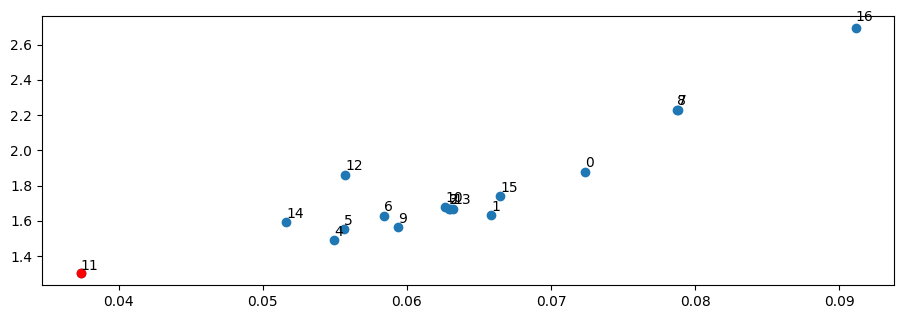

In [372]:
df_signal = df_signals(df, market_df) #create the dataframe with all the signals for all the ['Close'].columns

#for all the strategies, calculate the iloc[-2] mean & vol
best_signal_set = find_best_signal_set(df_signal, best='default', criteria='sharpe', test_size=.55, trace=True) 

#create the rebalancing table with the strategy having the best return
rebalancing_table = create_rebalancing_table(df_signal, tickers_to_see, best_signal_set[0])

#plot the returns with the given signals and tickers_to_see compare to other lists of tts
df_transaction = plot_return_with_signal(df_signal, best_signal_set, period_to_start, tickers_to_see, list_tickers_to_see, tts_mapping[tts])

In [14]:
ZZZ

NameError: name 'ZZZ' is not defined

# Machine learning

In [493]:
def alpha_to_positions(alpha, short=0):
    positions = alpha.rank(axis=1)
    positions = positions.div(positions.sum(axis=1), axis=0)
    if short == 1:
        positions = positions.sub(positions.mean(axis=1), axis=0)
    return positions

def sharpe_ratio(returns):
    returns = returns.replace(0, np.nan).dropna()
    cumprod = (1+returns).cumprod()
    net_return = (cumprod[-1] / cumprod[0] - 1) ** (1/ (returns.index[-1].year - returns.index[0].year))
    std = returns.std() * np.sqrt(nb_rolling)
    return net_return / std

def pnl_analytics(positions, returns, lag, tc=0):
    tickers = positions.columns
    shifted_returns = df_return[tickers].shift(-1)[positions.index[0]:positions.index[-1]]
    
    pnl = shifted_returns.mul(positions.shift(lag)).sum(axis=1)
    
    sharpe = pnl.replace(0,np.nan).dropna().mean() / pnl.replace(0,np.nan).dropna().std() * np.sqrt(nb_rolling)
    
    return pnl, sharpe

def analyze_alpha(positions, returns, title, lags=[0,1,2], short=0, plot=True):
    positions = alpha_to_positions(positions, short)
    
    fig = go.Figure()
    for lag in lags:
        pnl, sharpe = pnl_analytics(positions, returns, lag)
        pnl = (1+pnl).cumprod()
        fig.add_trace(go.Scatter(x = pnl.index, y = pnl, name=f'Lag: {lag} | Sharpe: {sharpe:.2f}'))
    fig.update_layout(title=title)
    if plot == True:
        fig.show()

In [581]:
plot = True
features = {}

In [586]:
alpha = df_signal['Close'].pct_change()
alpha_title = 'Pct_change'
analyze_alpha(alpha, df_return, alpha_title, short=0, plot=plot)
features[alpha_title] = alpha_to_positions(alpha)

In [587]:
alpha = - (df_signal['Volume'] * df_signal['Close'].pct_change()) / df_signal['Volume'].rolling(2).mean()
alpha_title = 'Volume'
analyze_alpha(alpha, df_return, alpha_title, short=0, plot=plot)
features[alpha_title] = alpha_to_positions(alpha)

In [588]:
def rolling_auto_corr_function(series, window):
    shifted_series = series.shift(1)
    auto_correlation = series.rolling(window, int(window/2)).corr(shifted_series)
    return auto_correlation

alpha = df_signal['Close'].pct_change().apply(rolling_auto_corr_function, args=([6]))
alpha_title = 'Autocorrelation'
analyze_alpha(alpha, df_return, alpha_title, short=0, plot=plot)
features[alpha_title] = alpha_to_positions(alpha)

In [585]:
def macd_distance(series):
    max_value = series.max()
    min_value = series.min()
    series = (series - min_value) / (max_value - min_value)
    
    short_ema = series.ewm(span=12, adjust=False, min_periods=12).mean()
    long_ema = series.ewm(span=26, adjust=False, min_periods=26).mean()

    macd = short_ema - long_ema
    macd_signal = macd.ewm(span=9, adjust=False, min_periods=9).mean()
    return (macd_signal - macd)

alpha = df_signal['Close'].pct_change().apply(macd_distance)
alpha_title = 'The great alpha'
analyze_alpha(alpha, df_return, alpha_title, short=0, plot=plot)

In [566]:
window = 6
label = df_return.rolling(window, 1).mean().stack()

In [569]:
train_features = {}
for feature_name in features:
    train_features[feature_name] = features[feature_name].shift(window).stack().reindex(label.index)
train_features = pd.concat(train_features, axis=1)

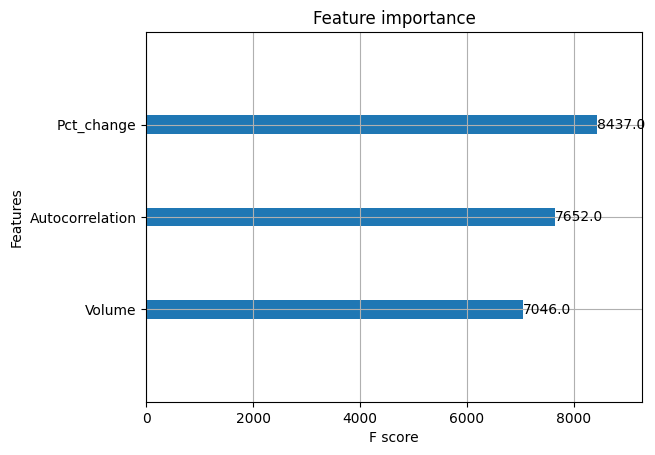

In [602]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from xgboost import plot_importance


X_train, X_test, y_train, y_test = train_test_split(train_features, label, test_size=0.5, random_state=11, shuffle=False)

# hyperparameters = xgb_cv.best_params_
#Below are the chosen hyperparameters
hyperparameters = {'colsample_bytree': 0.4, 'learning_rate': 0.00045, 'max_depth': 6, 'min_child_weight': 20, 
                   'n_estimators': 1250, 'random_state': 1, 'reg_lambda': 1, 'subsample': 0.65}

model = XGBRegressor(**hyperparameters).fit(X_train, y_train)
#model.save_model('final_model_Guillaume_Maximilian.json')
#model.load_model('final_model_Guillaume_Maximilian.json')
plot_importance(model, max_num_features=11);

In [603]:
# Reformat features for predictions
# Aligning to label index as well as shifting is not needed anymore
predict_features = pd.concat(features, axis=1).stack().loc['2017':]

# Make predictions using the previously fitted model
predictions = model.predict(predict_features)

# Reformat predictions to get a proper dataframe
predictions = pd.Series(predictions, index = predict_features.index).unstack()

In [604]:
# Display performance
display(pd.DataFrame(pd.Series(model.get_xgb_params()).dropna(), columns=['hyperparameters']))
analyze_alpha(
        positions=predictions,
        returns=df_return,
        title = f"XGB Predictions, In-Sample",
        lags = [0,1,2])

,hyperparameters
objective,reg:squarederror
colsample_bytree,0.4
learning_rate,0.00045
max_depth,6
min_child_weight,20
random_state,1
reg_lambda,1
subsample,0.65


In [ ]:
#1 stock

lanew=df_signal.filter(like='BBWI').dropna()
lanew.columns=lanew.columns.droplevel(1)
X=lanew
Y=lanew.iloc[:,:1]
#Y=np.sign(Y.pct_change().shift(-1)).replace(-1,0).dropna()
Y=Y.pct_change().shift(-1).dropna()
#Y=pd.cut(lanew.iloc[:,:1]['Close'].pct_change().shift(-1),5,labels=np.arange(5))

new_X = pd.DataFrame()
#new_X['Last_Close'] = np.sign(X.Close.diff())
new_X['Last_Close_2'] = X.Close.diff(2)
new_X['Last_Close_5'] = X.Close.diff(5)
new_X['Last_Close_14'] = np.sign(X.Close.diff(14))
new_X['Last_Close_30'] = np.sign(X.Close.diff(30))

new_X['Volume'] = np.log(X['Volume'].rolling(20).mean())

new_X['bands_2'] = ((X['upperband2']-X['lowerband2']).diff())

new_X['MA'] = ((X['MA']-X['MA2']).diff())
new_X['macd'] = np.sign((X['macd']-X['macd_signal']).diff())
new_X['macd'] = np.array(pd.cut(X['macd']-X['macd_signal'], 5, labels=np.arange(5)))
new_X['beta'] = X['beta'].diff()
new_X['rsi'] = np.array(pd.cut(X['rsi'], bins=30, labels=np.arange(0,30), retbins=False)) #retbins is the delimiter for each bin as a scalar of np arange
new_X['candle'] = X['High'] - X['Low']
#new_X['Target_Sum'] = new_X['Last_Close'].shift(2).rolling(14).sum()

new_X = new_X.reindex(Y.index).dropna()
Y = Y.reindex(new_X.index)
new_X

In [ ]:
#multiple

big_Y=np.sign(df_signal['Close'].pct_change().shift(-1)).melt(ignore_index=False,value_name='Close')['Close'].replace(-1,0)
Y=big_Y

X_vol=np.log(df_signal['Volume'].pct_change().rolling(20).mean()).melt(ignore_index=False, value_name='Volume')['Volume']
X_bands_2=(df_signal['upperband2']-df_signal['lowerband2']).pct_change().melt(ignore_index=False, value_name='bands_2')['bands_2']
X_beta=df_signal['beta'].diff().melt(ignore_index=False, value_name='beta')['beta']
X_candle=(df_signal['High']-df_signal['Low']).pct_change().melt(ignore_index=False, value_name='Candle')['Candle']
X_rsi=round(7*df_signal['rsi'].melt(ignore_index=False, value_name='rsi')['rsi']/7,0)
X_macd=np.sign((df_signal['macd']-df_signal['macd_signal']).diff()).melt(ignore_index=False, value_name='macd')['macd']
X_ma=np.sign((df_signal['MA']-df_signal['MA2'])).melt(ignore_index=False, value_name='ma')['ma']
X_chg3=df_signal['Close'].pct_change(3).melt(ignore_index=False, value_name='chg3')['chg3']
new_X=pd.concat([X_vol,X_bands_2,X_beta,X_candle,X_rsi,X_macd,X_ma], axis=1)
new_X=pd.concat([X_vol,X_beta,X_candle,X_bands_2,X_chg3], axis=1)

new_df=pd.concat([Y,new_X],axis=1).dropna()
Y=new_df.iloc[:,:1]
new_X=new_df.iloc[:,1:]

In [ ]:
#no sign
big_Y=(df_signal['Close'].pct_change().shift(-1)).melt(ignore_index=False,value_name='Close')['Close']#.replace(-1,0)
Y=big_Y

X_vol=np.log(df_signal['Volume'].pct_change().rolling(20).mean()).melt(ignore_index=False, value_name='Volume')['Volume']
X_bands_2=(df_signal['upperband2']-df_signal['lowerband2']).pct_change().melt(ignore_index=False, value_name='bands_2')['bands_2']
X_beta=df_signal['beta'].diff().melt(ignore_index=False, value_name='beta')['beta']
X_candle=(df_signal['High']-df_signal['Low']).pct_change().melt(ignore_index=False, value_name='Candle')['Candle']
X_rsi=df_signal['rsi'].melt(ignore_index=False, value_name='rsi')['rsi']
X_macd=(df_signal['macd']-df_signal['macd_signal']).diff().melt(ignore_index=False, value_name='macd')['macd']
X_ma=(df_signal['MA']-df_signal['MA2']).melt(ignore_index=False, value_name='ma')['ma']
X_sma=(df_signal['MA']).melt(ignore_index=False, value_name='sma')['sma']
X_chg3=df_signal['Close'].pct_change(3).melt(ignore_index=False, value_name='chg3')['chg3']
new_X=pd.concat([X_vol,X_bands_2,X_beta,X_candle,X_rsi,X_macd,X_ma,X_sma], axis=1)
#new_X=pd.concat([X_vol,X_beta,X_candle,X_bands_2,X_chg3], axis=1)

new_df=pd.concat([Y,new_X],axis=1).dropna()
Y=new_df.iloc[:,:1]
new_X=new_df.iloc[:,1:]

In [ ]:
mask = np.triu(np.ones_like(pd.concat([Y,(new_X)],axis=1).corr(), dtype=bool), 1)

ax = sb.heatmap(pd.concat([Y,(new_X)],axis=1).corr(), cmap='coolwarm', cbar=1, annot=True, fmt='.0%', mask=mask)
for lab, annot in zip(ax.get_xticklabels(), ax.texts):
    text =  lab.get_text()
    if text == 'Close':
        lab.set_weight('bold')
        lab.set_color('red')
        annot.set_weight('bold')
        annot.set_color('red')

for a in ax.texts:
    if a.get_unitless_position()[0]==.5: #pourrait faire en get le lab.unitless_position[1] aussi
        a.set_color('yellow')

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
X_train, X_test, y_train, y_test = train_test_split(new_X, Y, test_size=0.3, random_state=42)

In [ ]:
param_grid = {'max_depth': np.linspace(2, 8, 6, dtype=int), 'min_samples_leaf': np.arange(2,15, dtype=int)}
rf=RandomForestClassifier()
model_cv=GridSearchCV(rf, param_grid, cv=5).fit(X_train, np.ravel(y_train))
print(model_cv.best_score_)
print(model_cv.best_estimator_)

In [ ]:
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.3, 0.1, 0.01, 0.001],
    'subsample': [0.5, 0.7, 1],
    'gamma': [0,1,2,3,4],
    'reg_lambda': [0,1,2,3,4,5]
}

#model = xgb.XGBClassifier()
model = xgb.XGBRegressor()
model_cv = GridSearchCV(model, param_grid, cv=5).fit(X_train, np.ravel(y_train))

print(model_cv.best_score_)
print(model_cv.best_estimator_)
#xgb.plot_importance(model)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('classifier', RandomForestClassifier(max_depth=8))
])

pipeline2 = Pipeline([
    ('scaler', MinMaxScaler()),
    ('classifier', xgb.XGBClassifier(max_depth=3, eta=0.225, reg_lambda=0))
])

pipeline3 = Pipeline([
    ('scaler', MinMaxScaler()),
    ('classifier', LogisticRegression())
])

pipeline4 = Pipeline([
    ('scaler', MinMaxScaler()),
    ('classifier', xgb.XGBRegressor(max_depth=3, eta=0.225, reg_lambda=0))
])

#model = RandomForestClassifier(max_depth=5).fit(X_train, np.ravel(y_train))
#model = pipeline.fit(X_train, np.ravel(y_train))
#model = xgb.XGBClassifier(max_depth=3, eta=0.225, gamma=1).fit(X_train, np.ravel(y_train))
#model = pipeline4.fit(X_train, np.ravel(y_train))
model = pipeline3.fit(X_train, np.ravel(y_train))


#model_preds = model.predict_proba(X_test) #xgbclassifier
#preds_df = pd.DataFrame(model_preds[:,1])
#model_preds = model.predict(X_test) xgbregressor
#preds_df = pd.DataFrame(model_preds)

In [ ]:
from sklearn import metrics
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))
print(metrics.classification_report(y_test, model.predict(X_test)))
fallout, sensitivity, thresholds = metrics.roc_curve(y_test, preds_df)
plt.plot(fallout, sensitivity, color = 'darkorange')
plt.plot([0, 1], [0, 1], linestyle = '--')
plt.fill_between(fallout, sensitivity, alpha=0.1)
plt.title(metrics.roc_auc_score(y_test, preds_df))
plt.show()

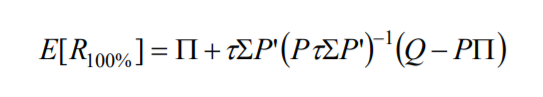


# Portfolio optimization

In [ ]:
#CONSTRAINTS
def constraint_weights(wght):
    return abs(np.sum(wght)) - 1

def min_weight(wght):
    return np.min(wght)-((1/rebalancing_table.loc[i].dropna().shape[0])/ratiominweight)

def constraint_corr(wght, min_weight, max_corr = 1):
    #Empirical hedging
    try:
        #print(i)
        last_correlation = (df['Close'][str(pd.to_datetime(i) - pd.DateOffset(weeks=int(cov_ma_period/1.25))):i][rebalancing_table.loc[i].dropna()]).pct_change().dropna().corr()
        #display(last_correlation)
        #print(last_correlation.min().sort_values(ascending=True)[0])
        if last_correlation.min().sort_values(ascending=True)[0] < max_corr:
            tickers_corr = last_correlation.min().sort_values(ascending=True).index[0]
            tickers_corr = tickers_corr, last_correlation[tickers_corr].idxmin()
            index_weights = rebalancing_table.loc[i].dropna()
            w1 = index_weights[index_weights==tickers_corr[0]].index.values[0]
            w2 = index_weights[index_weights==tickers_corr[1]].index.values[0]
            return abs(wght[w1]-min_weight)+abs(wght[w2]-min_weight) #equal ;  -0.2 = Wx1 > Wx2 (0.2)
        else:
            return 0
    except Exception as er:
        print(er)
        return 0


#OBJECTIVES
def minimize_variance(wght, i):
    return np.dot(wght, np.dot(cov_matrix(i), wght))

def maximize_sharpe(wght, i):
    return - retourpasse(wght, i) / minimize_variance(wght, i)

def maximize_sortino(wght, i):
    sd_negative_returns = df['Close'][str(pd.to_datetime(i) - pd.DateOffset(weeks=int(cov_ma_period))):i][rebalancing_table.loc[i].dropna()].pct_change()*nb_rolling
    sd_negative_returns[sd_negative_returns>0] = 0#garder seulement si >0
    sd_negative_returns = wght @ LedoitWolf().fit(sd_negative_returns.cov(ddof=1)).covariance_ @ wght #var negative_sd portfolio
    return - retourpasse(wght, i) / sd_negative_returns    

def maximize_treynor(wght,i):
    return - retourpasse(wght, i) / portfolio_beta(wght, i)

def minimize_diff_risk_parity(wght, i):
    cov_table = cov_matrix(i)
    covXweights = cov_table @ wght
    var_totale = wght @ cov_table @ wght
    objective_contribution = np.ones(cov_table.shape[1]) / cov_table.shape[1]
    risk_contribution = covXweights * wght / var_totale
    return sum(abs(risk_contribution-objective_contribution))

def best_cap_volume_weights(cap, method='proportional'): #to minimize: find best cap for vol weight strat
    weights_history = []
    print('Optimization for best cap with method = {}'.format(method), end='\r')
    for d in df.loc[period_to_start:].index:
        if rebalancing_table.loc[d].dropna().count()>min_pos:
            stock_signal=rebalancing_table.loc[d].dropna()
            weights_history.append(dict(zip(rebalancing_table.loc[d].dropna(), volume_weights(cap, d, method=method))))
        else:
            weights_history.append(dict(zip(df_return.columns.values,np.zeros(len(df_return.columns.values)))))
    final_ret = (1+(pd.DataFrame(weights_history, index=df.loc[period_to_start:].index).replace(np.nan,0) * df_return.loc[period_to_start:].shift(-1)).sum(axis=1)).prod()
    print(f"{final_ret:.2%}")
    return - final_ret


#FUNCTIONS
def cov_matrix(i):
    cov_matrix = (df['Close'][str(pd.to_datetime(i) - pd.DateOffset(weeks=int(cov_ma_period))):i][rebalancing_table.loc[i].dropna()].pct_change()*nb_rolling).cov(ddof=1)
    return cov_matrix

def retourpasse(wght, i):
    ret = df['Close'][:i][rebalancing_table.loc[i].dropna()].pct_change().iloc[-1] @ wght
    #ret = ((df['Close'].pct_change()[str(pd.to_datetime(i) - pd.DateOffset(weeks=int(cov_ma_period))):i][rebalancing_table.loc[i].dropna()].dropna() * wght).sum(axis=1)+1).prod()-1
    return ret

def expected_returns(wght, i, method):
    if method=='CAPM':
        mrp = nb_rolling * market_df.pct_change().loc[str(pd.to_datetime(i) - pd.DateOffset(weeks=int(cov_ma_period*1.5/4))):i,'Close'].mean() - ten_year.loc[i]/nb_rolling #:i or i
        capm_er = ten_year.loc[i]/nb_rolling + df_signal.loc[i:,('beta',rebalancing_table.loc[i].dropna())] * mrp
        capm_er = capm_er.to_numpy()[0] @ wght
        return capm_er

def portfolio_beta(wght, i):
    mkt_chg_ = market_df['Close'].pct_change()[str(pd.to_datetime(i) - pd.DateOffset(weeks=int(2*cov_ma_period))):i].dropna()
    pf_chg_ = (df['Close'].pct_change()[str(pd.to_datetime(i) - pd.DateOffset(weeks=int(2*cov_ma_period))):i][rebalancing_table.loc[i].dropna()].dropna() * wght).sum(axis=1)
    beta = mkt_chg_.cov(pf_chg_) / mkt_chg_.var()
    return beta

def cap_weight(weights, cap, method='proportional'): #weights with cap and redistribution method
    weights=np.array(weights)
    to_redistribute=sum(weights[weights>cap]-cap)
    if to_redistribute>0:
        weights[weights>cap]=cap
        missing=sum(weights[weights<cap])
        if method=='flip':
            weights[weights<cap]+=np.flip(weights[weights<cap]/missing)*to_redistribute
        elif method=='equal':
            weights[weights<cap]+=to_redistribute/np.count_nonzero(missing)
        elif method=='proportional':
            weights[weights<cap]+=weights[weights<cap]/missing*to_redistribute
    return weights

def volume_weights(cap, date, method='proportional'): #weights by volume
    wghts=(df['Volume'][rebalancing_table.loc[date].dropna()].div(df['Volume'][rebalancing_table.loc[date].dropna()].sum(axis=1), axis=0)).loc[date].values
    return cap_weight(wghts, cap, method)

def min_w_bound(min_w, positions):
    if positions * min_w > 1:
        min_w=.5/positions
    return min_w

def max_w_bound(positions, threshold):
    return threshold/positions

In [ ]:
start = time.time()

corr_constraint = 1 #Empirical hedging : Correlation constraint

constraints = [
    {'type': 'eq', 'fun': constraint_weights},
    {'type': 'eq', 'fun': constraint_corr, 'args': [.125, 0.4]} if corr_constraint==1 else None, #Empirical Hedging
    ]

#best_cap=minimize(best_cap_volume_weights, x0=0.5, bounds=[(0.1,0.75)]).x[0]

weights_history = []

total_period_days=(pd.to_datetime(df.iloc[-1].name)-pd.to_datetime(period_to_start)).days

for i in tqdm(df.loc[period_to_start:].index):

    stock_signal=rebalancing_table.loc[i].dropna()
    number_positions = stock_signal.count()

    #TIME
    remainingperiod=(pd.to_datetime(df.iloc[-1].name)-pd.to_datetime(i)).days
    percentageevolution=1-remainingperiod/total_period_days
    print(i.date(),'/', df.iloc[-1].name.date(), '\033[1m({:.2%})\033[0m:'.format(percentageevolution), 
          number_positions, 'positions   ', end='\r')

    if number_positions > min_pos:

        #Minimization
        min_w = 0.04725 
        max_w_ratio = 2.86
        bounds = [(min_w_bound(min_w, number_positions), max_w_bound(number_positions, max_w_ratio))] * stock_signal.shape[0]  
     
        wght_0 = np.ones(stock_signal.shape[0]) / stock_signal.shape[0]
        result = minimize(maximize_sortino, x0=wght_0, args=(i,), method='SLSQP', 
                          bounds=bounds, constraints=list(filter(None, constraints)), options={'disp':False})
        wght, cols = result.x, stock_signal.values
        #wght, cols = volume_weights(best_cap, i, method='proportional'), stock_signal.values
   
    else: #pas assez de signaux
        
        wght, cols = np.zeros(tickers_to_see.shape[0]) / tickers_to_see.shape[0] , np.array(tickers_to_see)

    weights_history.append(dict(zip(cols, wght)))

weights_df = pd.DataFrame(weights_history, columns = tickers_to_see, index = df.loc[period_to_start:].index).replace(np.nan,0)
weights_df = weights_df.reindex(sorted(weights_df.columns), axis=1)

std_portfolio = (1+(df_return.loc[period_to_start:].shift(-1)*weights_df).sum(axis=1)).std()
return_portfolio = (1+(df_return.loc[period_to_start:].shift(-1)*weights_df).sum(axis=1)).prod()

equal_w_df = weights_df.replace(0,np.nan).abs()
equal_w_df[equal_w_df>0] = 1
equal_w_df = equal_w_df.div(equal_w_df.count(axis=1), axis=0)

end = time.time()

print('\n\033[1mBacktesting Completed\033[0m: {:.0f} seconds / {:.1f} minutes\n\nReturn: {:.2f} | σ: {:.2%}'.format(end-start, (end-start)/60, return_portfolio, std_portfolio))

display(weights_df.applymap(lambda x: "{:.2%}".format(x)).iloc[-5:])

fig, axes = plt.subplots(1, 3, figsize=(16.5, 5.5))
pct_change_plot = df_return.shift(-1)[-3:] * weights_df.iloc[-3]
fig.suptitle('Weights from {} to {}'.format(pct_change_plot.index[0].strftime('%Y, %B %d'), pct_change_plot.index[-1].strftime('%Y, %B %d')), size=15)

for t in range(-3,0):
    last_w = weights_df.iloc[t]
    ax = axes[t+3]    
    last_w[last_w > 0.001].plot.pie(autopct='%.2f%%', shadow=True, normalize=True,
                                          explode=[.075] * last_w[last_w > 0.001].count(), ax=ax)
    ax.set_title('Weights - {}'.format(last_w.name.date()))
    ax.set_ylabel('')
    if not t==-1:
        amount = (pct_change_plot.iloc[t]).sum()
        square = patches.Rectangle((-0.23, -0.125), 0.46, 0.25, lw=1, edgecolor='black', facecolor='black', transform=ax.transData)
        ax.add_patch(square)
        center_text = ax.annotate(f"{amount:.2%}", (0, 0), fontsize=13, color='white', ha='center', va='center')
plt.show()

# Graphical representation

In [ ]:
%matplotlib Tk
%matplotlib inline

In [ ]:
fig, ax = plt.subplots(figsize=(26.5, 9.5))

returns = ((df_return.loc[period_to_start:].shift(-1))*weights_df).sum(axis=1)
returns_benchmark = market_df[period_to_start:]['Chg'].shift(-1).fillna(0)
excess_return = (returns-ten_year).dropna()
mkt_risk_premium = (returns_benchmark-ten_year).dropna()
avg_ret = returns.mean()
beta_alpha = np.polyfit(mkt_risk_premium, excess_return, deg=1)

if_rebalancedNonShifted_plot = (((df_return.loc[period_to_start:])*weights_df.shift(0)).sum(axis=1)+1).cumprod()
if_rebalancedShifted_plot = (((df_return.loc[period_to_start:].shift(-1))*weights_df).sum(axis=1)+1).cumprod()
if_eqw_signal = ((equal_w_df*df_return[period_to_start:].shift(-1)).sum(axis=1)+1).cumprod()

single_weight_equal = 1/df_return.shape[1]
if_init_plot = ((single_weight_equal*df_return.loc[period_to_start:].shift(-1)).sum(axis=1)+1).cumprod()

mkt_ret = (returns_benchmark+1).cumprod()

#reset index 0 = 1, add a pd Series with the index being the index before in the whole return_df, value = 1
prev_index = df_return.loc[:period_to_start].iloc[-1].name
if_rebalancedShifted_plot = pd.concat([pd.Series({prev_index: 1}), if_rebalancedShifted_plot])
if_eqw_signal = pd.concat([pd.Series({prev_index: 1}), if_eqw_signal])
if_init_plot = pd.concat([pd.Series({prev_index: 1}), if_init_plot])
mkt_ret = pd.concat([pd.Series({prev_index: 1}), mkt_ret])

for lag in [1,2,3]:
    (1+((df_return.loc[period_to_start:].shift(-1))*weights_df.shift(lag)).sum(axis=1)).cumprod().plot(alpha=0.105)

list_plot = [if_rebalancedShifted_plot,if_eqw_signal,if_init_plot,mkt_ret]

for num, plot in enumerate(list_plot, start=1):
    globals()[f'vol{num}'] = plot.pct_change().std()
    
if_rebalancedShifted_plot.plot(ax=ax, label='Rebalanced weights with signal (σ={:.2%})'.format(vol1), color='orangered')
if_eqw_signal.plot(ax=ax, linestyle='-', label='Equal weights with signal (σ={:.2%})'.format(vol2), color='navy')
if_init_plot.plot(ax=ax, linestyle='-', label='Equal weights (σ={:.2%})'.format(vol3), color ='orange', alpha=0.5)
mkt_ret.plot(ax=ax, color='cornflowerblue', linestyle= '-.', label='Benchmark (σ={:.2%})'.format(vol4))


crosses=np.argwhere(np.diff(np.sign(if_rebalancedShifted_plot - if_eqw_signal))).flatten()
if len(crosses)>1:
    plt.scatter(if_eqw_signal[crosses].index, if_eqw_signal[crosses], color='blue', marker='X')

avg_position=rebalancing_table[str(period_to_start):].count(axis=1).mean()

#Fill Between
ax.axhline(y=1, color='black', linestyle='--', linewidth=2)
ax.axvline(x=mkt_ret.index[-2], color='grey', linestyle = 'dotted', linewidth=2, alpha=0.45)

maxv=max(max(if_rebalancedShifted_plot), max(if_init_plot), max(if_eqw_signal), max(mkt_ret)) + 0.1
minv=min(min(if_rebalancedShifted_plot), min(if_init_plot), min(if_eqw_signal), min(mkt_ret)) - 0.05

ax.fill_between(mkt_ret.index, mkt_ret, maxv, color='limegreen', alpha=0.08105)
ax.fill_between(mkt_ret.index, mkt_ret, -3, color='red', alpha=0.08114)

ax.fill_between(if_rebalancedShifted_plot.index, if_rebalancedShifted_plot, if_eqw_signal, interpolate=True,
                where = if_rebalancedShifted_plot > if_eqw_signal, color='chartreuse', alpha=0.175)

ax.fill_between(if_rebalancedShifted_plot.index, if_rebalancedShifted_plot, if_eqw_signal, interpolate=True, 
                where = if_rebalancedShifted_plot < if_eqw_signal, color='red', alpha=0.155)

ax.set_ylim(minv, maxv)
ax.set_xlim(mkt_ret.index[0], mkt_ret.index[-1])


def max_drawdown(returns):
    cum_returns = np.cumprod(1 + (returns))
    previous_peaks = np.maximum.accumulate(cum_returns)
    drawdowns = (cum_returns - previous_peaks) / previous_peaks
    max_drawdown = np.min(drawdowns)
    max_dd_index = pd.to_datetime(drawdowns.idxmin())
    return max_drawdown, max_dd_index

max_drawdown = max_drawdown(returns)

#Annotations

colors = ['orangered','navy','orange','cornflowerblue']

for plot in zip(list_plot, colors): #Returns on the right
    plt.annotate(f'{round(plot[0][-1],2)}', 
             xy=(plot[0].index[-2], plot[0][-1]), 
             xytext=(20, 5), textcoords='offset points', color=plot[1], bbox=bbox_props)

data_to_annotate = rebalancing_table[str(period_to_start):df_return.shift(-1).index.max()].count(axis=1)
for idx, value in data_to_annotate.items(): #Number positions
    if value<=min_pos:
        plt.annotate(f"{value}", xy=(idx, minv), xytext=(-2, 5), textcoords='offset points', color='crimson')
    else:
        plt.annotate(f"{value}", xy=(idx, minv), xytext=(-2, 5), textcoords='offset points', color='darkgreen')

arrow_format = "{:.2}".format(if_rebalancedShifted_plot.min()) #Min
plt.annotate(arrow_format, xy=(if_rebalancedShifted_plot.idxmin(), if_rebalancedShifted_plot.min()), 
             xytext=(if_rebalancedShifted_plot.idxmin(),  if_rebalancedShifted_plot.min()+0.2),
             arrowprops=dict(facecolor='red', arrowstyle='->'), fontsize=12, color='red')
plt.scatter(if_rebalancedShifted_plot.idxmin(), if_rebalancedShifted_plot.min(), color='red', marker='v')

arrow_format = "{:.3}".format(if_rebalancedShifted_plot.max()) #Max
plt.annotate(arrow_format, xy=(if_rebalancedShifted_plot.idxmax(), if_rebalancedShifted_plot.max()), 
             xytext=(if_rebalancedShifted_plot.idxmax(),  if_rebalancedShifted_plot.max()*0.935),
             arrowprops=dict(facecolor='g', arrowstyle='->'), fontsize=12, color='g')
plt.scatter(if_rebalancedShifted_plot.idxmax(), if_rebalancedShifted_plot.max(), color='green', marker='^')

arrow_format = "{:.2%}".format(max_drawdown[0]) #Max DD
plt.annotate(arrow_format, xy=(max_drawdown[1], if_rebalancedShifted_plot[max_drawdown[1]]), 
             xytext=(max_drawdown[1],  if_rebalancedShifted_plot[max_drawdown[1]] - 0.15),
             arrowprops=dict(facecolor='b', arrowstyle='->'), fontsize=10, color='b')

box_props = dict(boxstyle='round,pad=0.2', facecolor='yellow', alpha=0.5)
text_format = "Average return per period: {:.2%}\nMaximum drawdown: {:.0%}".format(avg_ret, max_drawdown[0])
plt.text(0.111, 0.75, text_format, transform=plt.gca().transAxes, fontsize=10.5, color='black',
         bbox=box_props, ha='center', va='center')
box_props = dict(boxstyle='round,pad=0.2', facecolor='orange', alpha=0.5)
plt.text(0.5, 0.95, '\u03B2: {:.2f} \u03B1: {:.2f}'.format(beta_alpha[0], beta_alpha[1]), transform=plt.gca().transAxes, fontsize=10.5, color='black',
         bbox=box_props, ha='center', va='center')

#Plot characteristics
ax.set_xlabel('')
ax.set_ylabel('Cumulative return')
ax.set_title('Cumulative returns over {} periods ({} days) — {} tickers - average of {:.1f} positions\nW{}={:.2%} W{}={:.2%} len(σ)={}\nStrategy: {}'
             .format(len(weights_df), (pd.to_datetime(weights_df.iloc[-1].name)-pd.to_datetime(weights_df.iloc[0].name)).days, 
                     len(tickers_to_see), avg_position, get_sub('mn'), min_w, get_sub('max'), bounds[0][1], cov_ma_period, strategies[best_signal_set[0]]), fontsize=15)
fig.set_facecolor('snow') 
ax.set_yscale('linear')
ax.legend(shadow=True, title='Legend', ncols=2, fancybox=True, draggable=True)
ax.set_yticks(np.arange(np.round(minv,1), maxv, 0.1))
delimiter = len(rebalancing_table[period_to_start:].index)
delimiter = 1 if delimiter < 55 else 2 if 55 <= delimiter < 80 else 3
plt.xticks(rebalancing_table[period_to_start:].index[::delimiter], rebalancing_table[period_to_start:].index.strftime('%Y-%m')[::delimiter], rotation=45)
ax.minorticks_on()
ax.margins(x=0)
ax.grid(True, alpha=0.55, linestyle=':')
plt.show()

def plot_returns_per_share(weights_df, df_return, color_sharpe='red'):
    shares_ret=pd.DataFrame()
    returns_per_share=((weights_df.fillna(0)*df_return.loc[:,tickers_to_see].shift(-1)).dropna())
    shares_ret['Vol']=returns_per_share.std(numeric_only=True)*np.sqrt(nb_rolling)
    shares_ret['Ret']=(returns_per_share+1).prod() # = cumprod[-1]
    shares_ret = shares_ret.drop(shares_ret[shares_ret['Vol']==0].index, axis=0)
    
    plt.figure(figsize=(18.5, 4.5))
    x, y = shares_ret['Vol'], shares_ret['Ret']
    scaler = MinMaxScaler(feature_range=(10, 16))
    scaled_sizes = scaler.fit_transform(y.values.reshape(-1, 1)).flatten()
    plt.scatter(x, y, marker='o', color='green')
    shares_ret['Sharpe'] = shares_ret['Ret']/shares_ret['Vol']
    sharpe_max = shares_ret[shares_ret['Ret']>1].Sharpe.idxmax()
    plt.scatter(shares_ret.loc[sharpe_max].Vol, shares_ret.loc[sharpe_max].Ret, color=color_sharpe)
    y_lim = 1 + (plt.gca().get_ylim()[1]-1) / 50
    for i, txt in enumerate(shares_ret.index):
        plt.annotate(txt, (x[i], y_lim*y[i]), size=scaled_sizes[i], color='black')
    plt.axhline(y=1, linestyle='--', color='black')
    plt.xlabel('σ')
    plt.ylabel('Return')

def plot_returns_share_industry(weights_df, df_return):
    fig, ax = plt.subplots(1, 2, figsize=(18.5, 5.5))
    #Plot1
    (((weights_df.fillna(0)*df_return.loc[:,tickers_to_see].shift(-1)).dropna()+1).cumprod(axis=0)).plot(ax=ax[0])
    ax[0].axhline(y=1, color='black', linestyle='--')
    #Legend plot1
    new_legend=[]
    count_pos=weights_df[weights_df>0.01].count()
    for c in count_pos.index:
        count=count_pos[c]
        new_legend.append('{}: {}'.format(c, count))
    ax[0].legend(new_legend, loc='upper left', fontsize='x-small')
    ax[0].set_title('Return per share and executed buying signals')
    ax[0].set_yscale('linear')
    #Plot2
    ind_gains=(weights_df.fillna(0)*df_return.loc[:,tickers_to_see].shift(-1)).dropna().reset_index().melt(id_vars='Date', var_name='Ticker', value_name='Return').merge(industries, on='Ticker').groupby(['Industry','Date']).sum()['Return'].unstack(0)
    ind_gains=(1+ind_gains).cumprod()
    ind_gains.plot(ax=ax[1])
    #Legend plot2
    new_legend=[]
    count_ind=pd.concat([ind_gains.iloc[-1],industries[industries.Ticker.isin(weights_df.columns)].Industry.value_counts()], axis=1)
    for index, series in count_ind.iterrows():
        new_legend.append('{}: {} stocks'.format(index, int(series.values[1])))
        ax[1].annotate(int(series.values[1]), xy=(series.index[0], series.values[0]), 
                 xytext=(20, 0), textcoords='offset points', bbox=bbox_props)
    ax[1].legend(new_legend)
    ax[1].axhline(y=1, color='black', linestyle='--')
    ax[1].set_title('Return per industry and number of stocks')
    fig.show()
        
def return_regression(mkt_risk_premium, excess_return):
    func = np.poly1d(np.polyfit(mkt_risk_premium, excess_return, deg=1))
    significance_a = sm.OLS(excess_return,sm.add_constant(mkt_risk_premium)).fit().tvalues.iloc[0]
    
    fig, ax = plt.subplots(figsize=(16,3))
    ax.scatter(mkt_risk_premium, excess_return, label='Scatter Plot')
    ax.text(0.1, 0.9, '\u03B2: {:.2f} \u03B1: {:.2f} ({:.2f})'.format(beta_alpha[0], beta_alpha[1], significance_a), transform=plt.gca().transAxes, fontsize=10.5, color='black',
             bbox=box_props, ha='center', va='center')
    ax.plot(np.arange(mkt_risk_premium.min(), mkt_risk_premium.max(), 0.001), func(np.arange(mkt_risk_premium.min(), mkt_risk_premium.max(), 0.001)), color='red', label='Function')
    ax.axhline(0, ls='--', lw=.75, c='green')
    ax.set_ylabel('Portfolio return')
    ax.set_xlabel('Market Return')
    ax.set_title('Market return regression', fontsize=15)
    
    inset = fig.add_axes([0.65, 0.15, 0.25, 0.25])
    inset.plot(ten_year[mkt_risk_premium.index[0]:], c='black', label='Ten Year', alpha=.5)
    inset.set_title('Ten year')
    inset.set(xticklabels='', xticks=[], title='Ten Year')
    def y_fmt(x,y):
        return '{:.2%}'.format(y/100)
    inset.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(y_fmt))
    plt.show()


def market_plot3D(returns, returns_benchmark):
    
    dates = np.arange(0,len(returns.index))

    def calc_ret(w, date):
        return w * returns[date] + (1-w) * returns_benchmark[date]

    w = np.arange(0, 1.01, 0.2)
    dates_mesh, w_mesh = np.meshgrid(dates, w)

    rets = np.array([calc_ret(w_, date_) for w_, date_ in zip(np.ravel(w_mesh), np.ravel(dates_mesh))]).reshape(dates_mesh.shape)

    fig = plt.figure(figsize=(23,11.5))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(w_mesh, dates_mesh, (1+rets).cumprod(axis=1), 
                           cmap="turbo", edgecolor='black', alpha=.45)
    #fig.colorbar(surf, ax=ax, shrink=.31, aspect=5, label='Return')
    ax.set_xlabel('Portfolio Allocation')
    ax.set_ylabel('Date')
    ax.set_zlabel('Return')
    ax.set_title('3D Plot f(allocation) = Return')
    ax.set_yticklabels(returns.index.strftime('%b-%y'))
    ax.xaxis.set_major_formatter('{x:.0%}')
    ax.view_init(elev=20, azim=-40)
    plt.show()  

market_plot3D(returns, returns_benchmark)
plot_returns_per_share(weights_df, df_return)    
plot_returns_share_industry(weights_df, df_return)
return_regression(mkt_risk_premium, excess_return)

fig, ax = plt.subplots(figsize=(18.5, 4.5))
diff_eq_weighted=abs(weights_df-equal_w_df).sum(axis=1)
#pd.Series(diff_eq_weighted.mean(), index=diff_eq_weighted.index).plot()
ax.axhline(y=diff_eq_weighted.mean(), color='red')
ax.axhline(y=0, color='black')
diff_eq_weighted[diff_eq_weighted>-1].plot(ax=ax, color='black', alpha=0.5)
ax2=ax.twinx()
ax2.plot(returns.rolling(10).std(), color='orangered')
ax2.plot((equal_w_df*df_return[period_to_start:].shift(-1)).sum(axis=1).rolling(10).std(), color='navy')

ax.set_title('Absolute difference: Rebalanced positions vs equally-weighted positions — Volatilities')
ax.set_xlim(diff_eq_weighted.index.min(),diff_eq_weighted.index.max())
plt.show()

In [ ]:
%matplotlib Tk

In [ ]:
from matplotlib.animation import FuncAnimation

dates = np.arange(0,len(returns.index))

def calc_ret(w, date):
    return w * returns[date] + (1-w) * returns_benchmark[date]

w = np.arange(0, 1.01, 0.2)
dates_mesh, w_mesh = np.meshgrid(dates, w)

rets = np.array([calc_ret(w_, date_) for w_, date_ in zip(np.ravel(w_mesh), np.ravel(dates_mesh))]).reshape(dates_mesh.shape)

fig = plt.figure(figsize=(11,5))
ax = fig.add_subplot(111, projection='3d')
plot = [ax.plot_surface(w_mesh, dates_mesh, (1+rets).cumprod(axis=1), 
                       cmap="turbo", edgecolor='black', alpha=.45)]

def update(frame):

    plot[0].remove()
    new_zz = np.array([calc_ret(w_, date_) for w_, date_ in zip(np.ravel(w_mesh[frame:]), np.ravel(dates_mesh[frame:]))]).reshape(dates_mesh.shape)
    #zz_new = np.sin(xx + frame*0.1) + np.cos(yy + frame*0.1) 
    plot[0] = ax.plot_surface(xx, yy, new_zz, cmap='viridis')  

ani = FuncAnimation(fig, update, frames=range(25), interval=50, repeat=True)

plt.show()

In [ ]:
dates = np.arange(0,len(returns.index))

def calc_sharpe(w, date):
    return (w * (returns[date]) + (1-w) * (returns_benchmark[date])) / (w * returns.std() + (1-w) * market_df.Close.pct_change().rolling(5).std().reindex(returns.index)[date])

w = np.arange(0.1, 1.01, .5)
dates_mesh, w_mesh = np.meshgrid(dates, w)

rets = np.array([calc_sharpe(w_, date_) for w_, date_ in zip(np.ravel(w_mesh), np.ravel(dates_mesh))]).reshape(dates_mesh.shape)
#retss = np.array([calc_ret(w_, date_) for w_, date_ in zip(np.ravel(w_mesh), np.ravel(dates_mesh))]).reshape(dates_mesh.shape)

fig = plt.figure(figsize=(13, 20.5))
ax = fig.add_subplot(projection='3d')
#surf = ax.plot_surface(w_mesh, dates_mesh, rets, edgecolor='black', cmap="turbo", alpha=0.05)
surf2 = ax.plot_surface(w_mesh, dates_mesh, rets, edgecolor='black', cmap="Reds", alpha=0.5)
#cset = ax.contour(w_mesh, dates_mesh, (1+rets).cumprod(axis=1), offset=np.pi, label='slt')
#ax2 = fig.add_subplot(projection='3d', sharex=ax)
#surf2 = ax2.plot_surface(w_mesh, dates_mesh, (-1.5+(1+rets).cumprod(axis=1)), cmap="Reds", edgecolor='black', alpha=.85)
#fig.colorbar(surf, ax=ax, shrink=.31, aspect=5, label='Return')
ax.set_xlabel('Portfolio Allocation')
ax.set_ylabel('Date')
ax.set_zlabel('Return')
ax.set_title('3D Plot f(allocation) = Sharpe Ratio')
ax.set_yticklabels(returns.index.strftime('%b-%y'))
ax.xaxis.set_major_formatter('{x:.0%}')
ax.view_init(elev=30, azim=-30)
plt.tight_layout()
plt.show()  

In [ ]:
import numpy as np
import plotly.graph_objects as go

dates = np.arange(0, len(returns.index))

w = np.arange(0, 1.01, 0.2)
dates_mesh, w_mesh = np.meshgrid(dates, w)

rets = np.array([calc_sharpe(w_, date_) for w_, date_ in zip(np.ravel(w_mesh), np.ravel(dates_mesh))]).reshape(dates_mesh.shape)

date_labels = [returns.index[i].strftime('%b-%y') for i in range(len(returns.index))]

fig = go.Figure(data=[go.Surface(z=rets, x=w_mesh, y=dates_mesh)])
fig.update_layout(title='3D Plot f(allocation) = Return',
                  scene=dict(xaxis_title='Portfolio Allocation',
                             yaxis_title='Date',
                             zaxis_title='Return',
                             yaxis=dict(tickmode='array', tickvals=dates, ticktext=date_labels),
                             xaxis_tickformat=':.2%',
                             aspectmode='manual',
                             aspectratio=dict(x=2, y=1, z=0.5),
                             camera=dict(eye=dict(x=-1.25, y=-1.25, z=0.7))),
                  )
fig.show()

In [ ]:
#If rebalancing weights
avg_position=rebalancing_table.count(axis=1).mean()

print('Over {} periods ({} days) with {} tickers and an average of {:.1f} positions:\n'.format(len(weights_df), (pd.to_datetime(weights_df.iloc[-1].name)-pd.to_datetime(weights_df.iloc[0].name)).days,len(tickers_to_see), avg_position))
reb_w_totR=(((df_return.loc[period_to_start:])*weights_df).sum(axis=1)+1).cumprod()[-1]
reb_w_totRshifted=(((df_return.loc[period_to_start:].shift(-1))*weights_df).sum(axis=1)+1).cumprod()[-1]
avg_ret_noPositionDate=(df_return.loc[weights_df[(weights_df.sum(axis=1) == 0)].index]*(1/df_return.loc[weights_df[(weights_df.sum(axis=1) == 0)].index].shape[1])).sum(axis=1).mean()
print(Fore.RED)
print('Rebalanced weights:'+Style.RESET_ALL+'\nNon-shifted: {:.2%}\nShifted: {:.2%}   Average return per period: {:.2%}\nMarket: {:.2%}\n\nNo-position period average return (eq-w): {:.2%}\nEqually-weighted with signal: {:.2%}'.format(reb_w_totR, reb_w_totRshifted, avg_ret, mkt_ret[-1], avg_ret_noPositionDate, if_eqw_signal[-1]))

#If Initial/Last weights
init_w_tot=(((1/df_return.shape[1])*df_return.loc[period_to_start:]).sum(axis=1)+1).cumprod()[-1]
lst_w_tot=((weights_df.iloc[-1]*df_return.loc[period_to_start:]).sum(axis=1)+1).cumprod()[-1]
print('\n\nInitial-weights (equal): {:.2%}\nLast-weights: {:.2%}'.format(init_w_tot ,lst_w_tot))

# Same weight

In [ ]:
#df_return=prices.pct_change()
df_return=df.reset_index()['Close'][tickers_to_see].pct_change()
covm=df_return.cov(ddof=1)
display(covm.iloc[:3])

initial_weights = np.ones(covm.shape[1]) / covm.shape[1]
covm_array = covm.to_numpy()
bounds = [(0, .35)] * covm.shape[1]

minreturn=0.00
minweight=0

In [ ]:
def objective(weights):
    return np.dot(np.dot(weights, covm), weights)

def constraint_weights(weights):
    return abs(np.sum(weights)) - 1

def constraint_return(weights):
    return (df_return.mean()*weights).sum() - minreturn

def constraint_div(weights):
    return (weights)-minweight

constraints = [
    {'type': 'eq', 'fun': constraint_weights},
    #{'type': 'ineq', 'fun': constraint_return},
    #{'type': 'ineq', 'fun': constraint_div},
]

result = minimize(objective, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)

optimal_weights = result.x

covm_weighted = objective(optimal_weights)
covm_weighted = result.fun

retour = (df_return.mean()*optimal_weights).sum()

In [ ]:
tableau_resultats = [
    #["Poids optimaux", formatted_weights],
    ["Somme des poids", "{:.1f}".format(optimal_weights.sum())],
    ["Variance", '{:.4%}'.format(covm_weighted)],
    ["Volatilité", '{:.3%}'.format(covm_weighted**0.5)],
    ["Volatilité annuelle", '{:.3%}'.format(np.sqrt(252)*covm_weighted**0.5)],
    ["Retour total", '{:.3%}'.format(retour)],
    ["Retour annuel", '{:.3%}'.format(retour*252)]
]

vareq=np.dot(np.dot(initial_weights, covm_array), initial_weights)
returneq=(df_return.mean()*initial_weights).sum()

eq_resultats = [
    ["Poids par action", '{:.2%}'.format(initial_weights[0])],
    ["Variance", '{:.4%}'.format(vareq)],
    ["Volatilité", '{:.3%}'.format(vareq**0.5)],
    ["Volatilité", '{:.3%}'.format(np.sqrt(252)*vareq**0.5)],
    ["Retour total", '{:.3%}'.format(returneq)],
    ["Retour annuel", '{:.3%}'.format(returneq*252)]
]
print(Fore.RED + "Optimized portfolio"+ Style.RESET_ALL)
finweights=pd.DataFrame(optimal_weights,index=tickers_to_see,columns=['Weights']).applymap(lambda x: "{:.2%}".format(x)).sort_index().T
display(finweights)
for ligne in tableau_resultats:
    print("{: <20} {}".format(ligne[0] + ":", ligne[1]))
    
print(Fore.BLUE + "\nEqually-weighted portfolio"+ Style.RESET_ALL)
for ligne in eq_resultats:
    print("{: <20} {}".format(ligne[0] + ":", ligne[1]))

# 

In [ ]:
def random_color_generator():
    #inds_color=industries.loc[industries.loc[:,'Ticker'].isin(tickers_to_see),:].copy()
    #unique_industries = inds_color.loc[:,'Industry'].unique()
    #industry_color_mapping = {industry: random_color_generator() for industry in unique_industries}
    #inds_color.loc[:,'Color'] = inds_color.loc[:,'Industry'].map(industry_color_mapping)
    return 'rgb'+str((random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)))